# Model Time Series for COVID

## import

In [1]:
%matplotlib inline

# figure lib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# data useful lib
import pandas as pd
import numpy as np

# helper lib
import shutil
import os, stat
import re
import datetime
import math

# read json from http
import json
import urllib.request

# read csv from http
import io
import requests

# model lib
import tensorflow as tf
from sklearn.metrics import mean_absolute_error


## Definitions

In [2]:
PATH_TO_SAVE_DATA = "."
PATH_DF_POS_FR = PATH_TO_SAVE_DATA + '/' + 'df_pos_fr.csv'
PATH_DF_TEST_FR = PATH_TO_SAVE_DATA + '/' + 'df_test_fr.csv'
PATH_JSON_METEO_FR = PATH_TO_SAVE_DATA + '/' + 'data_meteo_fr.json'
PATH_DF_FEAT_FR = PATH_TO_SAVE_DATA + '/' + 'df_feat_fr.csv' 
PATH_GEO_DEP_FR = PATH_TO_SAVE_DATA + '/sources/geofrance/' + 'departments.csv'
PATH_MDL_SINGLE_STEP = PATH_TO_SAVE_DATA + '/' + "mdl_single_step_pos_fr"
PATH_MDL_MULTI_STEP = PATH_TO_SAVE_DATA + '/' + "mdl_multi_step_pos_fr"
PATH_MDL_MULTI_TFLITE = PATH_TO_SAVE_DATA + '/' + \
    'serverless/tensorflow-lite-on-aws-lambda'
PATH_MDL_MULTI_TFLITE_FILE = PATH_MDL_MULTI_TFLITE + '/' + \
    "converted_model.tflite"
PATH_SERVERLESS = PATH_MDL_MULTI_TFLITE + '/' + 'serverless.yml'

date_format = "%Y-%m-%d"

#NB_POS_DATE_MIN_DF_FEAT = 140734 # on 13/05/2020
NB_POS_DATE_MIN_DF_FEAT = 140227 # on 12/05/2020



URL_PREDICT = 'https://yl0910jrga.execute-api.us-east-2.amazonaws.com/dev/infer'

# model 
PAST_HISTORY = 14 # days used to predict next values in future
FUTURE_TARGET = 7 # nb predict days later
STEP = 1

# plot
NB_DAY_PLOT = FUTURE_TARGET*9

##  Helper functions

In [3]:
# FOR MODEL
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    '''
    Create dataset for training : create each samples (timeseries data)
    '''
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

# FOR DATES
def add_days(str_date_0, nb_days_CV):
    '''
    add days to string dates
    '''
    date_format = "%Y-%m-%d"
    date_last = datetime.datetime.strptime(str_date_0, date_format)
    date_start = date_last + datetime.timedelta(days=nb_days_CV)
    str_date_start = date_start.strftime(date_format)
    return str_date_start

def generate_list_dates(str_date_0, str_date_1, date_format=None):
    if date_format is None:
        date_format = "%Y-%m-%d"
    date_0 = datetime.datetime.strptime(str_date_0, date_format)
    date_1 = datetime.datetime.strptime(str_date_1, date_format)
    delta = date_1 - date_0
    if delta.days > 0:
        return [(date_0 + \
                 datetime.timedelta(days=I)).strftime(date_format) \
               for I in range(1, delta.days+1)]
    else:
        return None

# EXTRACT DATA
def extract_data_world(df_world_melt, df_death_melt, str_filter, str_value):
    '''
    Extract data cases & death for one country by date from df_world_melt
    
    '''

    df_cases = df_world_melt[df_world_melt[str_filter] == str_value]
    

    s_cases = df_cases.groupby("date")["nb_cases"].sum()
    df_cases_out = pd.DataFrame(columns=["date", "nb_cases"])
    df_cases_out["nb_cases"] = s_cases.values
    df_cases_out["date"] = s_cases.index
    
    if df_death_melt is not None:
        df_death = df_death_melt[df_death_melt[str_filter] == str_value]
        s_death = df_death.groupby("date")["nb_death"].sum()
        df_death_out = pd.DataFrame(columns=["date", "nb_death"])
        df_death_out["nb_death"] = s_death.values
        df_death_out["date"] = s_death.index
        return df_cases_out, df_death_out 
    else:
        print("one output ...")
        return df_cases_out 

# For Training plots
def create_time_steps(length):
    '''
    create time steps
    '''
    return list(range(-length, 0))

def plot_train_history(history, title):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()
    
# save file before update
def clean_file(path_file_name):
    '''
    Clean file already traited : rename file with date
    '''
    try:
        d = datetime.datetime.now()
        str_date = '_' + d.strftime("%Y%m%d_%H_%M_%S")
       
        res_re = re.search('\.\w+$', path_file_name)
        
        path_file_name_saved = \
            path_file_name[0:res_re.start()] + str_date + res_re.group(0)
         
        shutil.move(path_file_name, path_file_name_saved) 
        print('File {} moved!'.format(path_file_name_saved))
    except:
        print('File {} does not exist!'.format(path_file_name))

## Retrieve data

In [4]:
# load dep
#df_dep_fr = pd.read_csv(PATH_GEO_DEP_FR)
##############################
# GOUV FR : UPDATE DATA 
#
# New source : "https://www.data.gouv.fr/fr/datasets/r/406c6a23-e283-4300-9484-54e78c8ae675"
# https://www.data.gouv.fr/fr/datasets/donnees-relatives-aux-resultats-des-tests-virologiques-covid-19/#_
URL_CSV_GOUV_FR = \
    'https://www.data.gouv.fr/fr/datasets/r/406c6a23-e283-4300-9484-54e78c8ae675'

# patch 29/07/2020 : SSL error patch
req = requests.get(URL_CSV_GOUV_FR).content
df_gouv_fr_raw = pd.read_csv(io.StringIO(req.decode('utf-8')), sep=";", 
                            low_memory=False)
#df_gouv_fr_raw = df_gouv_fr_raw_0.copy()
# past treat data upper cases -> lower cases
if "t" not in df_gouv_fr_raw.columns:
    df_gouv_fr_raw["t"] =  df_gouv_fr_raw["T"]
if "p" not in df_gouv_fr_raw.columns:
    df_gouv_fr_raw["p"] =  df_gouv_fr_raw["P"]
# patch : clear data in double !!!
df_gouv_fr_raw = df_gouv_fr_raw[df_gouv_fr_raw["cl_age90"] != 0]

# creation of table data : 't':tested 'p':positive
# data =  f(line : date, dep / col: t) => f(line : date / col: dep = f(t)) 
pt_fr_test = pd.pivot_table(df_gouv_fr_raw, values=['t', 'p'], 
                            index=["jour"],
                    columns=["dep"], aggfunc=np.sum) 
pt_fr_test["date"] = pt_fr_test.index


# age (new feature)
# date / dep age pos test
# =>  date / pos mean(age) 
df_gouv_fr_raw_0 = df_gouv_fr_raw.copy()
df_gouv_fr_raw_0["prod_p_age"] = \
    df_gouv_fr_raw_0["p"] * df_gouv_fr_raw_0["cl_age90"]
df_gouv_fr_raw_0["prod_t_age"] = \
    df_gouv_fr_raw_0["t"] * df_gouv_fr_raw_0["cl_age90"]
ser_p_age = df_gouv_fr_raw_0.groupby("jour") \
    ["prod_p_age"].sum() / df_gouv_fr_raw_0.groupby("jour")["p"].sum()
df_age = pd.DataFrame(index=ser_p_age.index, columns=["pos_mean_age"], 
                      data=ser_p_age.values)
ser_t_age = df_gouv_fr_raw_0.groupby("jour") \
    ["prod_t_age"].sum() / df_gouv_fr_raw_0.groupby("jour")["t"].sum()
df_age["test_mean_age"] = ser_t_age

# prepare data positive
df_pos_fr = pt_fr_test["p"].copy()
df_pos_fr.index = pt_fr_test["date"].index
df_pos_fr["date"] = df_pos_fr.index
df_pos_fr["age"] = df_age["pos_mean_age"].copy()
# save data pos
df_pos_fr.to_csv(PATH_DF_POS_FR, index=False)

# prepare data tested
df_test_fr = pt_fr_test["t"].copy()
df_test_fr.index = pt_fr_test["date"].index
df_test_fr["date"] = df_test_fr.index
df_test_fr["age"] = df_age["test_mean_age"].copy()
# save data tested
df_test_fr.to_csv(PATH_DF_TEST_FR, index=False)


In [5]:
df_gouv_fr_raw

,dep,jour,P,T,cl_age90,t,p
0,01,2020-05-13,0,16,9,16,0
1,01,2020-05-13,1,17,19,17,1
2,01,2020-05-13,0,33,29,33,0
3,01,2020-05-13,1,72,39,72,1
4,01,2020-05-13,0,54,49,54,0
...,...,...,...,...,...,...,...
145282,978,2020-09-16,2,18,59,18,2
145283,978,2020-09-16,1,11,69,11,1
145284,978,2020-09-16,0,2,79,2,0
145285,978,2020-09-16,0,0,89,0,0


In [6]:
df_pos_fr

dep,01,02,03,04,05,06,07,08,09,10,...,971,972,973,974,975,976,977,978,date,age
jour,,,,,,,,,,,,,,,,,,,,,
2020-05-13,9,14,0,1,0,19,4,6,1,3,...,0,4,0,1,0,9,0,0,2020-05-13,60.987528
2020-05-14,9,14,2,2,7,24,4,2,0,0,...,0,4,0,1,0,9,0,0,2020-05-14,60.435714
2020-05-15,5,11,2,1,0,20,5,5,1,5,...,0,0,0,1,0,12,0,0,2020-05-15,59.838991
2020-05-16,0,7,2,0,0,2,0,1,0,0,...,0,1,0,1,0,0,0,0,2020-05-16,60.158076
2020-05-17,0,2,1,0,0,2,0,0,0,0,...,0,0,0,3,0,0,0,0,2020-05-17,61.568345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-12,43,24,12,5,1,97,9,15,1,9,...,50,10,16,48,0,6,1,2,2020-09-12,42.223205
2020-09-13,4,6,2,1,2,24,2,4,0,4,...,28,0,2,25,0,5,0,0,2020-09-13,43.935146
2020-09-14,93,44,23,23,15,347,14,23,24,19,...,252,39,34,122,0,31,1,13,2020-09-14,42.094819


In [7]:
df_test_fr

dep,01,02,03,04,05,06,07,08,09,10,...,971,972,973,974,975,976,977,978,date,age
jour,,,,,,,,,,,,,,,,,,,,,
2020-05-13,333,295,163,99,28,823,64,100,52,223,...,26,84,2,355,0,24,0,1,2020-05-13,55.432085
2020-05-14,437,524,147,117,66,755,134,108,68,191,...,74,197,2,247,0,34,0,2,2020-05-14,54.802156
2020-05-15,449,331,171,93,32,1103,143,119,48,258,...,79,146,4,519,1,44,0,5,2020-05-15,54.307859
2020-05-16,146,141,77,30,9,271,41,55,30,33,...,10,17,2,311,0,3,0,47,2020-05-16,54.356873
2020-05-17,32,56,39,18,15,121,21,27,5,10,...,4,7,3,199,0,4,0,0,2020-05-17,58.074841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-12,686,536,612,145,39,1308,335,581,102,257,...,188,217,261,1353,0,89,27,17,2020-09-12,42.087248
2020-09-13,111,73,180,40,27,292,30,170,10,78,...,83,17,39,441,0,58,2,5,2020-09-13,44.271802
2020-09-14,1651,976,1186,385,249,4522,711,805,661,586,...,1163,874,710,2479,2,478,18,63,2020-09-14,42.523465


In [8]:
def create_url_meteo_date(str_date):
    # str_date = 2020-05-10
    num_records_max = 10000
    return 'https://public.opendatasoft.com/api/records/1.0/search/' + \
        f'?dataset=donnees-synop-essentielles-omm&q=&rows={num_records_max}' + \
        f'&sort=date&refine.date={str_date}'

def get_data_meteo_by_date(str_date):
    '''
    get data meteo for 1 day on date str_date 
    
    example : get_data_meteo_by_date("2020-01-24")
    '''
    # download raw json object
    url = create_url_meteo_date(str_date)
    data = urllib.request.urlopen(url).read().decode()
    # parse json object
    return json.loads(data)

def get_data_meteo_by_list(list_date):
    '''
    Retrieve data meteo for a list of dates
    '''
    print("list_date :", list_date)
    for I, date_curr in enumerate(list_date):
        
        data_curr = get_data_meteo_by_date(date_curr)
        
        if I:
            data_out["records"] = data_out["records"] + data_curr["records"]
        else:
            data_out = data_curr.copy()
            
    return data_out
    

def create_url_meteo(num_records, num_start=0):
    # https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm  
    return 'https://public.opendatasoft.com/api/records/1.0/search/' + \
        f'?dataset=donnees-synop-essentielles-omm&q=&rows={num_records}' + \
        f'&sort=date&start={num_start}'

def get_data_meteo(num_records, num_start=0):
    # num_records max = 10000
    # download raw json object
    url = create_url_meteo(num_records, num_start)
    data = urllib.request.urlopen(url).read().decode()
    # parse json object
    return json.loads(data)
def days_between(str_date_0, str_date_1):
    '''
    calculate days between 2 string dates
    '''
    date_format = "%Y-%m-%d"
    
    date_0 = datetime.datetime.strptime(str_date_0, date_format)
    date_1 = datetime.datetime.strptime(str_date_1, date_format)
    delta = date_1 - date_0
    '''date_start = date_last + datetime.timedelta(days=nb_days_CV)
    str_date_start = date_start.strftime(date_format)
    return str_date_start'''
    return delta

# function about data meteo from json 
def get_data_meteo_date_list(data): 
    return np.unique([data["records"][I]["fields"]["date"][0:10] \
                for I in range(len(data["records"]))]).tolist()
def get_data_meteo_date_min(data):
    list_date = get_data_meteo_date_list(data)
    return min(list_date)[0:10]
def get_data_meteo_date_max(data):
    list_date = get_data_meteo_date_list(data)
    return max(list_date)[0:10]

#days_between(df_pos_fr.date.min(), )

In [9]:
# first time : 
if os.path.isfile(PATH_JSON_METEO_FR):
    f_reload_from_start = False
    f_load_missing = False
    # load
    with open(PATH_JSON_METEO_FR) as f:
        data_meteo = json.load(f)
    # check start date
    date_meteo_start = get_data_meteo_date_min(data_meteo)
    delta_days = days_between(df_pos_fr.date.min(), date_meteo_start)
    if delta_days.days > 0:
        print(f"Must reload from start, {delta_days.days} days missing")
        f_reload_from_start = True
    # check last date
    date_meteo_end = get_data_meteo_date_max(data_meteo)
    delta_days = days_between(date_meteo_end, df_pos_fr.date.max())
    if delta_days.days > 0:
        print(f"Must load more last days, {delta_days.days} days missing")
        f_load_missing = True
    
    # determine list of days to download
    list_dates = None
    if f_reload_from_start:
        # all dates between [FORCED]
        list_dates = df_pos_fr["date"].tolist()
    elif f_load_missing:
        # from date
        list_dates = df_pos_fr["date"].tolist()
        # remove days already downloaded:
        list_remove = get_data_meteo_date_list(data_meteo)
        #get_data_meteo_date_list(data_meteo)
        for item_curr in  list_remove:
            try:
                list_dates.remove(item_curr)
            except:
                print(f'{item_curr} not found in dates list')
    else:
        # download NOT needed
        list_dates = None
else:
    # all dates between [FORCED]
    f_reload_from_start = True
    f_load_missing = True
    list_dates = df_pos_fr["date"].tolist()
# if download needed
if list_dates is not None:
    data_meteo_new = get_data_meteo_by_list(list_dates)
    print(f'{len(data_meteo_new["records"])} records downloaded')
    
    if f_reload_from_start:
        # reload all
        data_meteo = data_meteo_new
    else:
        # add data
        data_meteo["records"] = data_meteo["records"] + \
            data_meteo_new["records"]      
    # save
    with open(PATH_JSON_METEO_FR, 'w') as outfile:
        json.dump(data_meteo, outfile)
else:
    print("Data meteo OK")


Must load more last days, 12 days missing
list_date : ['2020-09-05', '2020-09-06', '2020-09-07', '2020-09-08', '2020-09-09', '2020-09-10', '2020-09-11', '2020-09-12', '2020-09-13', '2020-09-14', '2020-09-15', '2020-09-16']
5749 records downloaded


In [10]:
str_date = '2020-09-05'
num_records_max = 10000
'https://public.opendatasoft.com/api/records/1.0/search/' + \
        f'?dataset=donnees-synop-essentielles-omm&q=&rows={num_records_max}' + \
        f'&sort=date&refine.date={str_date}'

'https://public.opendatasoft.com/api/records/1.0/search/?dataset=donnees-synop-essentielles-omm&q=&rows=10000&sort=date&refine.date=2020-09-05'

In [11]:
list_dates = df_pos_fr["date"].tolist()
print(list_dates)
# remove days already downloaded:
list_remove = get_data_meteo_date_list(data_meteo)
print(list_remove)

['2020-05-13', '2020-05-14', '2020-05-15', '2020-05-16', '2020-05-17', '2020-05-18', '2020-05-19', '2020-05-20', '2020-05-21', '2020-05-22', '2020-05-23', '2020-05-24', '2020-05-25', '2020-05-26', '2020-05-27', '2020-05-28', '2020-05-29', '2020-05-30', '2020-05-31', '2020-06-01', '2020-06-02', '2020-06-03', '2020-06-04', '2020-06-05', '2020-06-06', '2020-06-07', '2020-06-08', '2020-06-09', '2020-06-10', '2020-06-11', '2020-06-12', '2020-06-13', '2020-06-14', '2020-06-15', '2020-06-16', '2020-06-17', '2020-06-18', '2020-06-19', '2020-06-20', '2020-06-21', '2020-06-22', '2020-06-23', '2020-06-24', '2020-06-25', '2020-06-26', '2020-06-27', '2020-06-28', '2020-06-29', '2020-06-30', '2020-07-01', '2020-07-02', '2020-07-03', '2020-07-04', '2020-07-05', '2020-07-06', '2020-07-07', '2020-07-08', '2020-07-09', '2020-07-10', '2020-07-11', '2020-07-12', '2020-07-13', '2020-07-14', '2020-07-15', '2020-07-16', '2020-07-17', '2020-07-18', '2020-07-19', '2020-07-20', '2020-07-21', '2020-07-22', '2020

In [12]:
data_meteo["records"][0]

{'datasetid': 'donnees-synop-essentielles-omm',
 'recordid': 'd7b0b15b2787cb0ba0a185bd69ef9c2bf2ab33ea',
 'fields': {'code_epci': '200067205',
  'ch': '10',
  'vv': 20000.0,
  'cm': '20',
  'cl': '32',
  'nom_reg': 'Normandie',
  'w1': '0',
  'rr6': 0.0,
  'code_dep': '50',
  'numer_sta': '07020',
  'libgeo': 'La Hague',
  'nom_dept': 'Manche',
  'mois_de_l_annee': 5,
  'rr3': 0.0,
  'rr24': 0.0,
  'tend24': 90.0,
  'per': -10.0,
  'tend': 210.0,
  'temps_present': 'État du ciel inchangé dans l’ensemble',
  'rafper': 16.5,
  'latitude': 49.725167,
  'td': 276.15,
  'nnuage1': 4.0,
  'tc': 9.700000000000045,
  'pres': 101650.0,
  'pmer': 101760,
  'nom': 'PTE DE LA HAGUE',
  'nom_epci': 'CA du Cotentin',
  'type_de_tendance_barometrique': 'En baisse ou stationnaire, puis en hausse, ou en hausse, puis en hausse plus rapide',
  'dd': 60,
  'code_reg': '28',
  'ww': '2',
  'cod_tend': '3',
  'ff': 11.8,
  'date': '2020-05-13T21:00:00+00:00',
  'altitude': 6,
  'hnuage1': 1000.0,
  'coordon

In [13]:
def get_rec_by_date(data_meteo, date_str):
    '''
    get one date data 
    '''
    
    # date_str = '2020-05-14'
    list_rec = []
    for rec_curr in data_meteo["records"]:
        if rec_curr['fields']["date"][0:10] == date_str:
            list_rec.append(rec_curr)
    data_out = data_meteo.copy()
    data_out["records"] = list_rec
    return data_out

def select_rec_by_station(data_meteo):
    '''
    Select list of list of data by station
    '''
    list_station = [data_meteo["records"][I]['fields']['numer_sta'] \
                    for I in range(len(data_meteo["records"]))]
    list_station = np.unique(list_station).tolist()
    
    list_rec = []
    for sta_curr in list_station:
        list_rec_curr = []
        for rec_curr in data_meteo["records"]:
            if rec_curr['fields']['numer_sta'] == sta_curr:
                list_rec_curr.append(rec_curr)
        list_rec.append(list_rec_curr)
            
    return list_rec


def get_field_in_list(list_rec, field_name):
    '''
    get a field from a list of list of data 
    '''
    list_field = []
    for I in range(len(list_rec)):
        list_field_curr = []
        for J in range(len(list_rec[I])):
            try:
                list_field_curr.append(list_rec[I][J]["fields"][field_name])
            except:
                continue
        if list_field_curr != []:
            list_field.append(list_field_curr)
    return list_field

def calculate_mean_field(list_field, fun):
    """
    calculate mean with fun on list of data
    """
    list_by_sta = []
    for list_curr in list_field:
        list_by_sta.append(fun(list_curr))

    return np.mean(list_by_sta)

def calc_list_mean_field(data_meteo, fieldname, fun):
    list_date = get_data_meteo_date_list(data_meteo)
    list_mean = []
    for date_curr in list_date:
        data_out = get_rec_by_date(data_meteo, date_curr)
        list_by_sta = select_rec_by_station(data_out)
        list_field = get_field_in_list(list_by_sta, fieldname)
        list_mean.append(calculate_mean_field(list_field, fun))
    return list_mean

In [14]:
# create features for model

# add meteo data

list_t_min = calc_list_mean_field(data_meteo, "t", min)
list_t_max = calc_list_mean_field(data_meteo, "t", max)
list_u_min = calc_list_mean_field(data_meteo, "u", min)
list_u_max = calc_list_mean_field(data_meteo, "u", max)

dict_meteo = dict()
dict_meteo["date"] = get_data_meteo_date_list(data_meteo)
dict_meteo["t_min"] = list_t_min
dict_meteo["t_max"] = list_t_max
dict_meteo["u_min"] = list_u_min
dict_meteo["u_max"] = list_u_max

df_feat_fr = pd.DataFrame(data=dict_meteo)
df_feat_fr.columns = ["date", "T_min", "T_max", "H_min", "H_max"]
df_feat_fr.sort_values(by="date", inplace=True)
df_feat_fr.index = df_feat_fr["date"]

# add positive cases
df_pos_fr["pos"] = 0
list_dep = []
for col_curr in df_pos_fr.columns:
    if re.search("^\d", col_curr):
        list_dep.append(col_curr)

for dep_curr in list_dep:
    df_pos_fr["pos"] += df_pos_fr[dep_curr]

df_feat_fr["pos"] = df_pos_fr["pos"].copy()
df_feat_fr["age_pos"] = df_pos_fr["age"].copy()

# add tested cases
df_test_fr["test"] = 0
list_dep = []
for col_curr in df_test_fr.columns:
    if re.search("^\d", col_curr):
        list_dep.append(col_curr)

for dep_curr in list_dep:
    df_test_fr["test"] += df_test_fr[dep_curr]
    
df_feat_fr["test"] = df_test_fr["test"].copy()
df_feat_fr["age_test"] = df_test_fr["age"].copy()
# add num days
df_feat_fr['day_num'] = \
    df_feat_fr["date"].astype(np.datetime64).dt.strftime("%w")

# add nb_cases
arr_nb_cases = df_feat_fr["pos"].cumsum().values
df_feat_fr["nb_cases"] = NB_POS_DATE_MIN_DF_FEAT + arr_nb_cases

In [15]:
df_feat_fr

,date,T_min,T_max,H_min,H_max,pos,age_pos,test,age_test,day_num,nb_cases
date,,,,,,,,,,,
2020-05-13,2020-05-13,284.926667,290.505000,64.661017,88.135593,882,60.987528,38872,55.432085,3,141109
2020-05-14,2020-05-14,285.050000,290.963333,59.406780,84.847458,980,60.435714,41644,54.802156,4,142089
2020-05-15,2020-05-15,285.308333,291.920000,57.372881,82.966102,1031,59.838991,47093,54.307859,5,143120
2020-05-16,2020-05-16,284.956667,293.500000,53.741379,86.534483,291,60.158076,16171,54.356873,6,143411
2020-05-17,2020-05-17,285.598333,294.446667,49.879310,85.500000,139,61.568345,6280,58.074841,0,143550
...,...,...,...,...,...,...,...,...,...,...,...
2020-09-12,2020-09-12,287.893333,298.625000,46.627119,87.322034,3956,42.223205,79543,42.087248,6,395594
2020-09-13,2020-09-13,287.946667,300.263333,44.762712,86.593220,1434,43.935146,22292,44.271802,0,397028
2020-09-14,2020-09-14,289.485000,302.236667,42.203390,82.067797,12392,42.094819,202533,42.523465,1,409420


### save

In [16]:
# save 
clean_file(PATH_DF_FEAT_FR)
df_feat_fr.to_csv(PATH_DF_FEAT_FR, index=False)

File ./df_feat_fr_20200920_08_38_01.csv moved!


## Train/Test split

In [17]:
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]

df_feat_fr

,date,T_min,T_max,H_min,H_max,pos,age_pos,test,age_test,day_num,nb_cases
date,,,,,,,,,,,
2020-05-13,2020-05-13,284.926667,290.505000,64.661017,88.135593,882,60.987528,38872,55.432085,3,141109
2020-05-14,2020-05-14,285.050000,290.963333,59.406780,84.847458,980,60.435714,41644,54.802156,4,142089
2020-05-15,2020-05-15,285.308333,291.920000,57.372881,82.966102,1031,59.838991,47093,54.307859,5,143120
2020-05-16,2020-05-16,284.956667,293.500000,53.741379,86.534483,291,60.158076,16171,54.356873,6,143411
2020-05-17,2020-05-17,285.598333,294.446667,49.879310,85.500000,139,61.568345,6280,58.074841,0,143550
...,...,...,...,...,...,...,...,...,...,...,...
2020-09-12,2020-09-12,287.893333,298.625000,46.627119,87.322034,3956,42.223205,79543,42.087248,6,395594
2020-09-13,2020-09-13,287.946667,300.263333,44.762712,86.593220,1434,43.935146,22292,44.271802,0,397028
2020-09-14,2020-09-14,289.485000,302.236667,42.203390,82.067797,12392,42.094819,202533,42.523465,1,409420


In [9]:
# keep 25 Validation samples:
TRAIN_SPLIT = df_feat_fr.shape[0] - (2 * FUTURE_TARGET)
#TRAIN_SPLIT = 45
print(f"TRAIN_SPLIT = {TRAIN_SPLIT}")

TRAIN_SPLIT = 113


In [19]:
df_feat_fr["train"] = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat_fr.shape[0])]
df_feat_fr

,date,T_min,T_max,H_min,H_max,pos,age_pos,test,age_test,day_num,nb_cases,train
date,,,,,,,,,,,,
2020-05-13,2020-05-13,284.926667,290.505000,64.661017,88.135593,882,60.987528,38872,55.432085,3,141109,True
2020-05-14,2020-05-14,285.050000,290.963333,59.406780,84.847458,980,60.435714,41644,54.802156,4,142089,True
2020-05-15,2020-05-15,285.308333,291.920000,57.372881,82.966102,1031,59.838991,47093,54.307859,5,143120,True
2020-05-16,2020-05-16,284.956667,293.500000,53.741379,86.534483,291,60.158076,16171,54.356873,6,143411,True
2020-05-17,2020-05-17,285.598333,294.446667,49.879310,85.500000,139,61.568345,6280,58.074841,0,143550,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-12,2020-09-12,287.893333,298.625000,46.627119,87.322034,3956,42.223205,79543,42.087248,6,395594,False
2020-09-13,2020-09-13,287.946667,300.263333,44.762712,86.593220,1434,43.935146,22292,44.271802,0,397028,False
2020-09-14,2020-09-14,289.485000,302.236667,42.203390,82.067797,12392,42.094819,202533,42.523465,1,409420,False


## Exploration

Distribution of TRAIN / VALIDATION dataset :

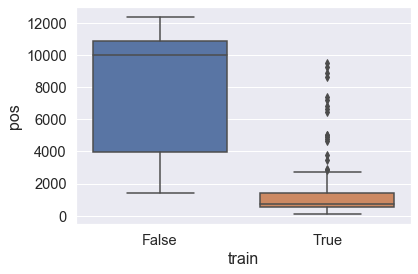

In [20]:
ax = sns.boxplot(x="train", y="pos", data=df_feat_fr)

### age

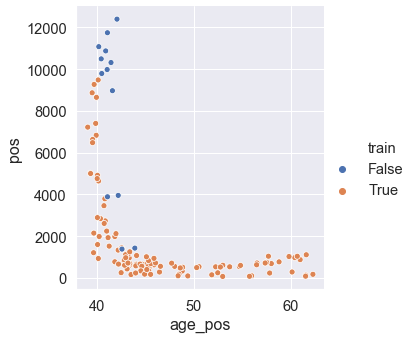

In [21]:
sns.relplot(x="age_pos", y="pos", hue="train", data=df_feat_fr);

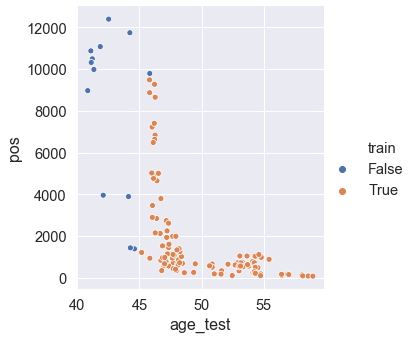

In [22]:
sns.relplot(x="age_test", y="pos", hue="train", data=df_feat_fr);

### Impact of day 

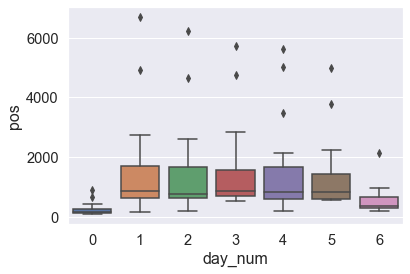

In [102]:
ax = sns.boxplot(x="day_num", y="pos", data=df_feat_fr)

=> It is not the reality. On weekend, a lot of local medical structures don't trace positive cases.

### Temperature impact

In [103]:
df_feat_fr["T_mean"] = 0.5 * (df_feat_fr["T_min"] + df_feat_fr["T_max"])

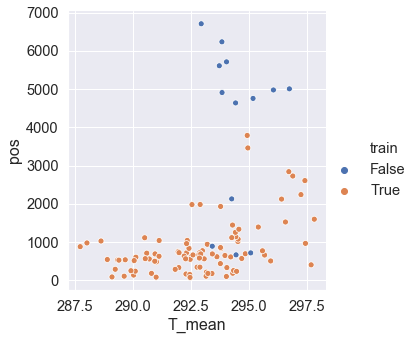

In [104]:
sns.relplot(x="T_mean", y="pos", hue="train", data=df_feat_fr);

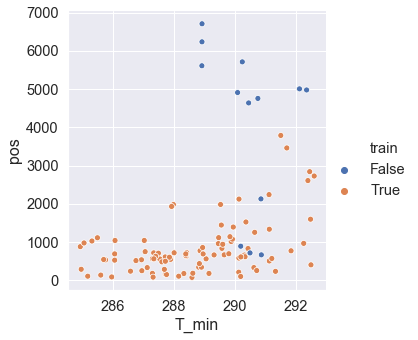

In [105]:
sns.relplot(x="T_min", y="pos", hue="train", data=df_feat_fr);

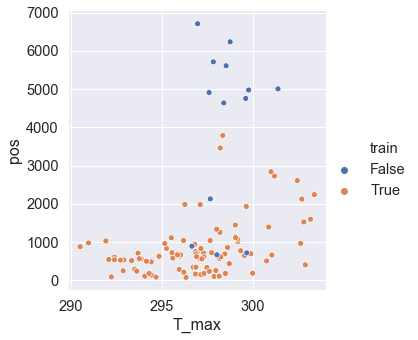

In [106]:
sns.relplot(x="T_max", y="pos", hue="train", data=df_feat_fr);

Impact of cold temperature :

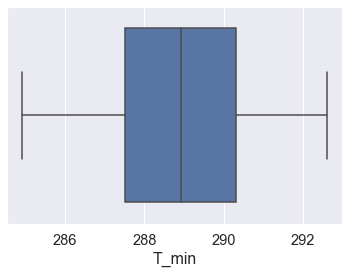

In [107]:
ax = sns.boxplot(x="T_min", data=df_feat_fr)

In [108]:
df_feat_fr["T_min"].mean()

288.92306795175534

In [109]:
(df_feat_fr["T_min"] < df_feat_fr["T_min"].mean()).value_counts()

True     54
False    53
Name: T_min, dtype: int64

In [110]:
(df_feat_fr["T_min"] < df_feat_fr["T_min"].median()).value_counts()

False    54
True     53
Name: T_min, dtype: int64

In [111]:
df_feat_fr["T_min"].median()

288.92166666666674

In [112]:
df_feat_fr["cold_min"] = df_feat_fr["T_min"] < df_feat_fr["T_min"].median()

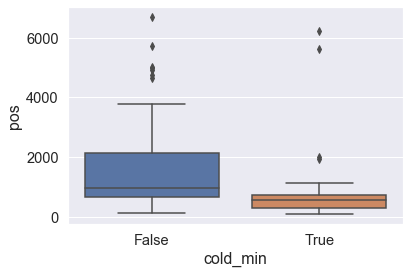

In [113]:
ax = sns.boxplot(x="cold_min", y="pos", data=df_feat_fr)

=> colder T min then less positive cases! (strange behaviour... opposite of flu ?)

Impact of T mean : 

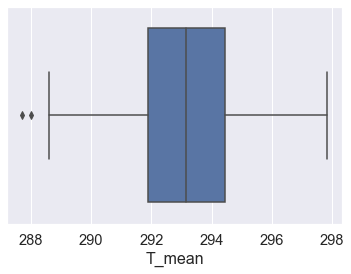

In [114]:
ax = sns.boxplot(x="T_mean", data=df_feat_fr)

In [115]:
df_feat_fr["T_mean"].median()

293.15083333333337

In [116]:
df_feat_fr["cold_mean"] = df_feat_fr["T_mean"] < df_feat_fr["T_mean"].median()

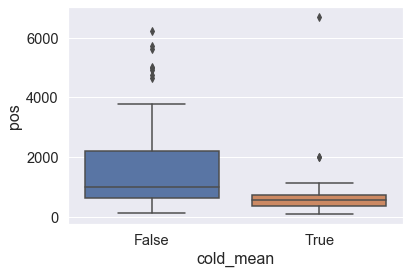

In [117]:
ax = sns.boxplot(x="cold_mean", y="pos", data=df_feat_fr)

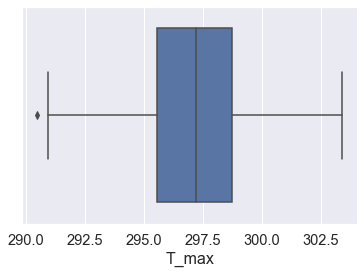

In [118]:
ax = sns.boxplot(x="T_max", data=df_feat_fr)

In [119]:
df_feat_fr["T_max"].median()

297.19666666666666

In [120]:
df_feat_fr["cold_max"] = df_feat_fr["T_max"] < df_feat_fr["T_max"].median()

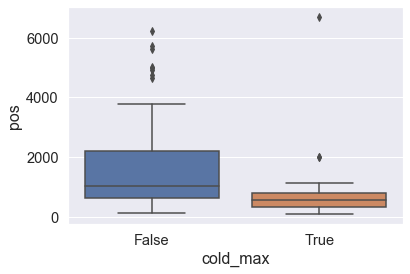

In [121]:
ax = sns.boxplot(x="cold_max", y="pos", data=df_feat_fr)

=> significant like with day_num

### Impact of Humidity

In [122]:
df_feat_fr["H_mean"] = 0.5 * (df_feat_fr["H_min"] + df_feat_fr["H_max"])

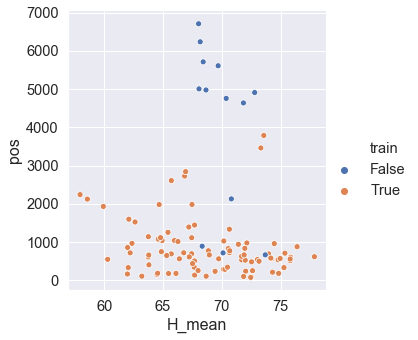

In [123]:
sns.relplot(x="H_mean", y="pos", hue="train", data=df_feat_fr);

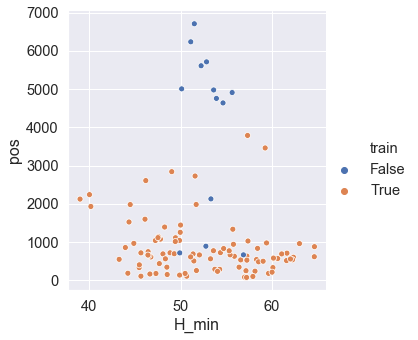

In [124]:
sns.relplot(x="H_min", y="pos", hue="train", data=df_feat_fr);

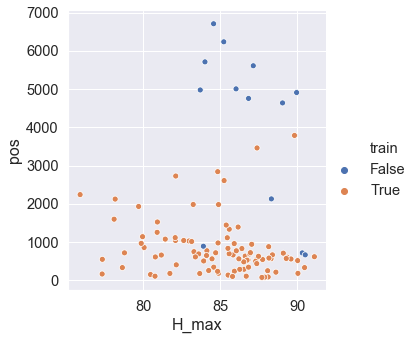

In [125]:
sns.relplot(x="H_max", y="pos", hue="train", data=df_feat_fr);

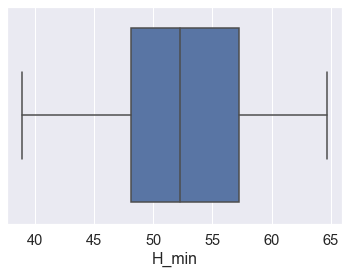

In [126]:
ax = sns.boxplot(x="H_min", data=df_feat_fr)

In [127]:
df_feat_fr["H_min"].median()

52.23728813559321

In [128]:
df_feat_fr["dry_min"] = df_feat_fr["H_min"] < df_feat_fr["H_min"].median()

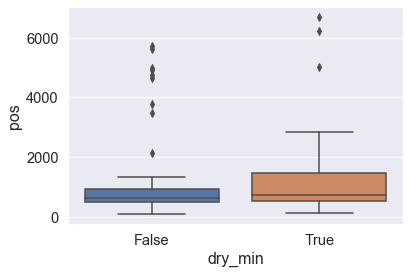

In [129]:
ax = sns.boxplot(x="dry_min", y="pos", data=df_feat_fr)

=> maybe dry more positive cases ?

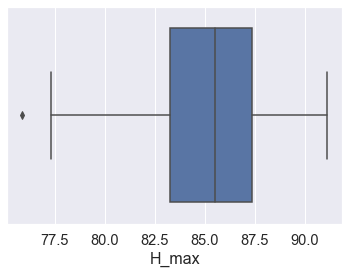

In [130]:
ax = sns.boxplot(x="H_max", data=df_feat_fr)

In [131]:
df_feat_fr["H_max"].median()

85.5

In [132]:
df_feat_fr["dry_max"] = df_feat_fr["H_max"] < df_feat_fr["H_max"].median()

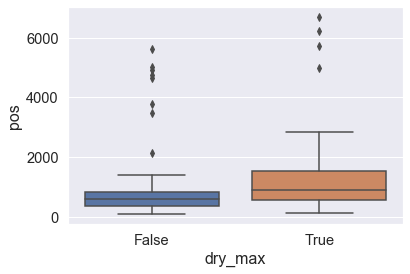

In [133]:
ax = sns.boxplot(x="dry_max", y="pos", data=df_feat_fr)

=> real impact of Hmax?

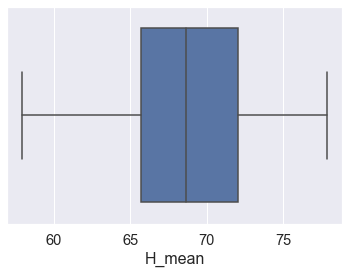

In [134]:
ax = sns.boxplot(x="H_mean", data=df_feat_fr)

In [135]:
df_feat_fr["H_mean"].median()

68.66964285714286

In [136]:
df_feat_fr["dry_mean"] = df_feat_fr["H_mean"] < df_feat_fr["H_mean"].median()

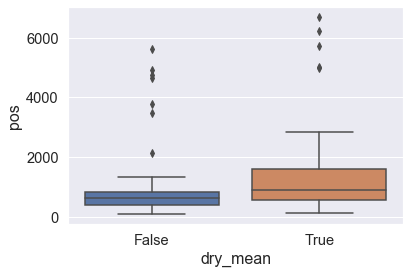

In [137]:
ax = sns.boxplot(x="dry_mean", y="pos", data=df_feat_fr)

=> Same maybe impact of humidity H_max => dryer then more positive cases ?

### Seasonality impact

In [138]:
df_feat_fr["month"] = df_feat_fr["date"].astype(np.datetime64).dt.month

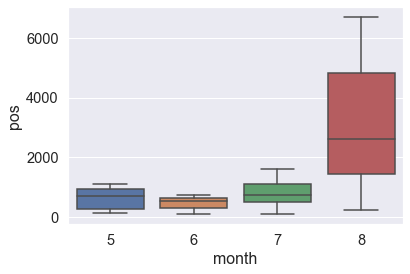

In [139]:
ax = sns.boxplot(x="month", y="pos", data=df_feat_fr)

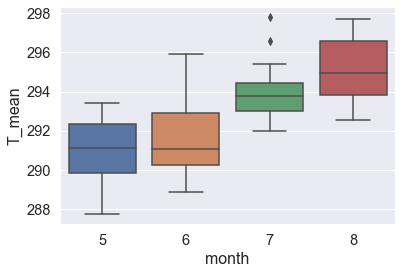

In [140]:
ax = sns.boxplot(x="month", y="T_mean", data=df_feat_fr)

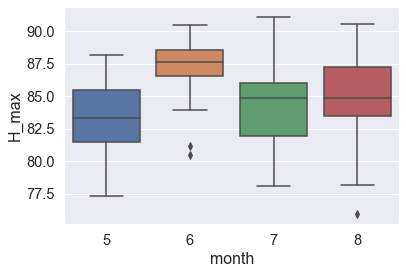

In [141]:
ax = sns.boxplot(x="month", y="H_max", data=df_feat_fr)

In [142]:
pt_month = df_feat_fr.pivot_table(values=["pos"],
                           index="month", aggfunc=np.sum)
pt_month

,pos
month,
5,11662
6,14090
7,24490
8,81074


### Nb Tested

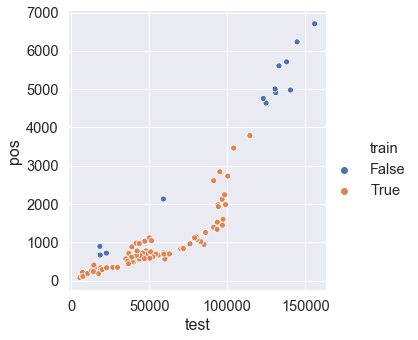

In [143]:
sns.relplot(x="test", y="pos", hue="train", data=df_feat_fr);

In [144]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_feat_fr["date"].astype(np.datetime64), 
                         y=df_feat_fr["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Nb. Tested"))
# Edit the layout
fig.update_layout(title='COVID-19 Tested  (France)',
                   yaxis_title='nb Tested')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1.1))
fig.show()

In [145]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_feat_fr["date"].astype(np.datetime64), 
                         y=100*df_feat_fr["pos"] / df_feat_fr["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Positive Rate"))
# Edit the layout
fig.update_layout(title='COVID-19 Positive rate  (France)',
                   yaxis_title='pos. rate [%]')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1.1))
fig.show()

## Prepare features

In [4]:
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]

In [5]:
features = df_feat_fr.copy().filter(items=['T_min', 'T_max', 'H_min',
                                           'H_max', 'pos', 'test', 'day_num',
                                          'age_pos', 'age_test'])
features

,T_min,T_max,H_min,H_max,pos,test,day_num,age_pos,age_test
date,,,,,,,,,
2020-05-13,284.926667,290.505000,64.661017,88.135593,882,38872,3,60.987528,55.432085
2020-05-14,285.050000,290.963333,59.406780,84.847458,980,41644,4,60.435714,54.802156
2020-05-15,285.308333,291.920000,57.372881,82.966102,1031,47093,5,59.838991,54.307859
2020-05-16,284.956667,293.500000,53.741379,86.534483,291,16171,6,60.158076,54.356873
2020-05-17,285.598333,294.446667,49.879310,85.500000,139,6280,0,61.568345,58.074841
...,...,...,...,...,...,...,...,...,...
2020-09-12,287.893333,298.625000,46.627119,87.322034,3956,79543,6,42.223205,42.087248
2020-09-13,287.946667,300.263333,44.762712,86.593220,1434,22292,0,43.935146,44.271802
2020-09-14,289.485000,302.236667,42.203390,82.067797,12392,202533,1,42.094819,42.523465


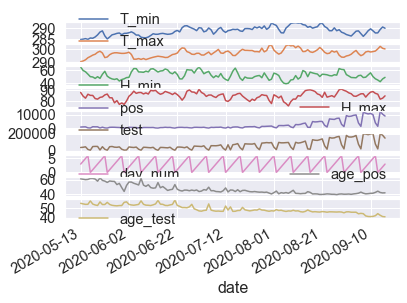

In [6]:
features.plot(subplots=True);

In [7]:
#TRAIN_SPLIT = 45

In [10]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [11]:
dataset = (dataset-data_mean)/data_std

## Single step model

Use past_history samples to predict in future forward STEP times

In [152]:
#(dataset, target, start_index, end_index, history_size,
#                      target_size, step, single_step=False)

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 4], 
                                                0, TRAIN_SPLIT, PAST_HISTORY,
                                                FUTURE_TARGET, STEP,
                                                single_step=True)

x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 4],
                                TRAIN_SPLIT-PAST_HISTORY, None, PAST_HISTORY,
                                FUTURE_TARGET, STEP,
                                single_step=True)

In [153]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (14, 9)


In [156]:
 x_train_single.shape[0]

79

In [154]:
BATCH_SIZE = x_train_single.shape[0]
BATCH_SIZE_VAL = y_val_single.shape[0]
BUFFER_SIZE = TRAIN_SPLIT
tf.random.set_seed(0)

In [155]:
 y_val_single.shape[0]

7

In [157]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, 
                                                        y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE). \
    batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, 
                                                      y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE_VAL).repeat()


In [158]:
data_test = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
data_test = data_test.cache().shuffle(BUFFER_SIZE). \
    batch(BATCH_SIZE).repeat(2)
list_test = list(data_test.as_numpy_iterator())
print(len(list_test))
print(len(list_test[0]))
print(list_test[0][0].shape)
print(list_test[0][1].shape)

2
2
(79, 14, 9)
(79,)


In [159]:
train_data_single.take(31)

<TakeDataset shapes: ((None, 14, 9), (None,)), types: (tf.float64, tf.float64)>

In [160]:
x_train_single.shape

(79, 14, 9)

In [161]:
x_train_single.shape[-2:]

(14, 9)

In [162]:
train_data_single

<RepeatDataset shapes: ((None, 14, 9), (None,)), types: (tf.float64, tf.float64)>

In [163]:
val_data_single

<RepeatDataset shapes: ((None, 14, 9), (None,)), types: (tf.float64, tf.float64)>

In [164]:
x_train_single.shape[-2:]

(14, 9)

In [165]:
'''for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)'''

'for x, y in val_data_single.take(1):\n    print(single_step_model.predict(x).shape)'

In [167]:
features.shape[1]

9


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 00605: early stopping
Run #0 : val_loss = 2.524973453113724


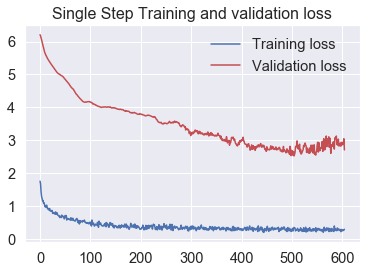

INFO:tensorflow:Assets written to: ./mdl_single_step_pos_fr\assets

 Run #1
Run #1 : val_loss = 2.2358210522795043


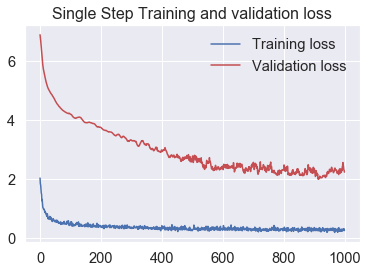

INFO:tensorflow:Assets written to: ./mdl_single_step_pos_fr\assets

 Run #2
Restoring model weights from the end of the best epoch.
Epoch 00806: early stopping
Run #2 : val_loss = 3.058806292670827

 Run #3
Restoring model weights from the end of the best epoch.
Epoch 00637: early stopping
Run #3 : val_loss = 1.7260173310436109


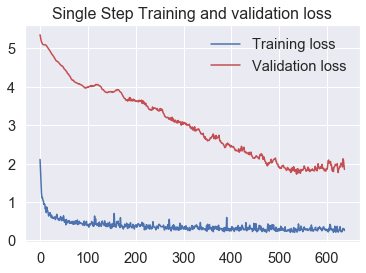

INFO:tensorflow:Assets written to: ./mdl_single_step_pos_fr\assets

 Run #4
Restoring model weights from the end of the best epoch.
Epoch 00919: early stopping
Run #4 : val_loss = 2.0463231045866332

 Run #5
Restoring model weights from the end of the best epoch.
Epoch 00731: early stopping
Run #5 : val_loss = 2.3233858612612637

 Run #6
Restoring model weights from the end of the best epoch.
Epoch 00632: early stopping
Run #6 : val_loss = 2.2280437019900234

 Run #7
Restoring model weights from the end of the best epoch.
Epoch 00736: early stopping
Run #7 : val_loss = 1.8416109415322357

 Run #8
Restoring model weights from the end of the best epoch.
Epoch 00598: early stopping
Run #8 : val_loss = 2.688285496576205

 Run #9
Restoring model weights from the end of the best epoch.
Epoch 00910: early stopping
Run #9 : val_loss = 1.8911744448000631
Wall time: 2min 42s


In [173]:
%%time
NB_TRY = 10
EVALUATION_INTERVAL = 1
EPOCHS = 1000
patience = 100
# Hyper-parameters
# lr = 1e-2 val_loss = 1.6623600816733817 (without dropout, patience 30 epoch 400 NB TRY 10)
lr = 1e-2
decay = 1e-6
momentum = 0.9
nesterov = True 


sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
                          nesterov=nesterov) 

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                   verbose=1, patience=patience,
                                   restore_best_weights=True)


list_loss = []

for I in range(NB_TRY):
    print("")
    print(f" Run #{I}")
    single_step_model = tf.keras.models.Sequential()

    '''single_step_model.add(tf.keras.layers.LSTM(4, return_sequences=True,
                                            input_shape=x_train_single.shape[-2:]))

    single_step_model.add(tf.keras.layers.LSTM(2, activation='relu'))'''

    single_step_model.add(tf.keras.layers.LSTM(features.shape[1],
                                        input_shape=x_train_single.shape[-2:]))
    
    single_step_model.add(tf.keras.layers.Dropout(0.2))
    
    single_step_model.add(tf.keras.layers.BatchNormalization())

    single_step_model.add(tf.keras.layers.Dense(1))

    single_step_model.compile(optimizer=sgd_2, loss='mae')


    single_step_history = single_step_model.fit(train_data_single, 
                                            epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=1,
                                            callbacks=[es],
                                            verbose=0)

    # re- eval best epoch model
    y_val_pred = single_step_model.predict(x_val_single)
    mae_curr = mean_absolute_error(y_val_single, y_val_pred)
    if (I == 0):
        list_loss.append(mae_curr)
        
    
    # find the best model
    print(f"Run #{I} : val_loss = {mae_curr}")
    if (mae_curr < np.min(list_loss)) | (I == 0):
        # plot history
        plot_train_history(single_step_history,
                   'Single Step Training and validation loss')
        # save
        if not(os.path.isdir(PATH_MDL_SINGLE_STEP)):
            os.mkdir(PATH_MDL_SINGLE_STEP)
        single_step_model.save(PATH_MDL_SINGLE_STEP)
        
    if (I != 0):   
        list_loss.append(mae_curr)
        

In [174]:
# reload best model
single_step_model = tf.keras.models.load_model(PATH_MDL_SINGLE_STEP)

In [175]:
y_val_pred = single_step_model.predict(x_val_single)
mean_absolute_error(y_val_single, y_val_pred)

1.7260171948044227

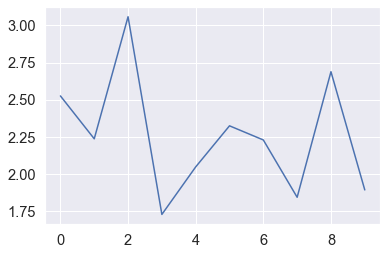

In [176]:
plt.plot(list_loss)

In [177]:
'''plot_train_history(single_step_history,
                   'Single Step Training and validation loss')'''

"plot_train_history(single_step_history,\n                   'Single Step Training and validation loss')"

In [178]:


def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

In [179]:
for x, y in val_data_single.take(1):
    print(x.shape)

(7, 14, 9)


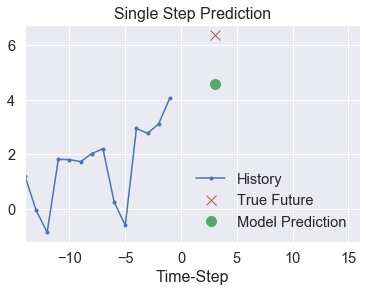

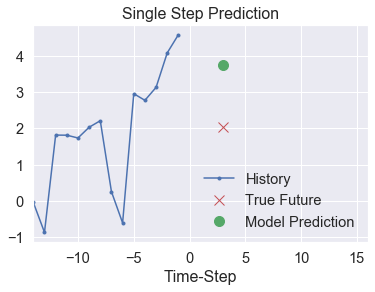

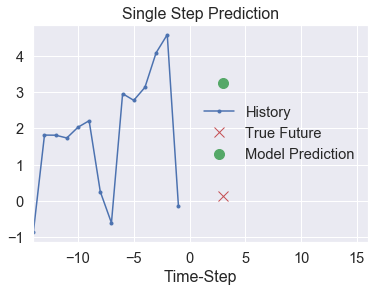

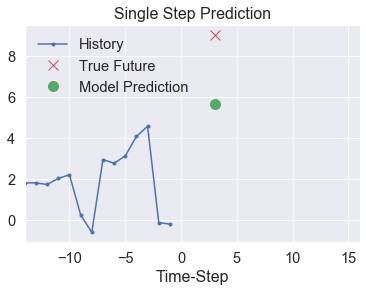

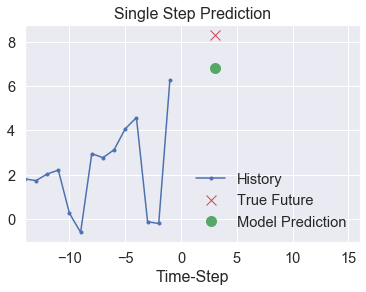

In [181]:
for x, y in val_data_single.take(1):
    for I in range(5):
        plot = show_plot([x[I][:, 4].numpy(), y[I].numpy(),
                        single_step_model.predict(x)[I]], 3,
                       'Single Step Prediction')
        plot.show()


## Multi-step model

### Helper functions

In [24]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 4]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

### data 14D_to_7D

In [12]:
TRAIN_SPLIT

113

In [13]:
dataset.shape

(127, 9)

In [14]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 4], 
                                0, TRAIN_SPLIT, PAST_HISTORY,
                                FUTURE_TARGET, STEP, single_step=False)

x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 4],
                                TRAIN_SPLIT-PAST_HISTORY, None, PAST_HISTORY,
                                FUTURE_TARGET, STEP, single_step=False)

In [15]:
y_train_multi.shape

(99, 7)

In [16]:
print ('{} Single window of past history : {}'.format(x_train_multi.shape[0],
                                                      x_train_multi[0].shape))
print ('\n {} Target temperature to predict : {}'.format(y_train_multi.shape[0],
                                                        y_train_multi[0].shape))

99 Single window of past history : (14, 9)

 99 Target temperature to predict : (7,)


In [17]:
BATCH_SIZE = x_train_multi.shape[0]
BATCH_SIZE_VAL = y_val_multi.shape[0]
BUFFER_SIZE = TRAIN_SPLIT
tf.random.set_seed(0)

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, 
                                                       y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE_VAL).repeat()

print("For Training : ")
print("BATCH_SIZE :", BATCH_SIZE)
print("BUFFER_SIZE :", BUFFER_SIZE)
print("\nFor validation : ")
print("BATCH_SIZE_VAL :", BATCH_SIZE_VAL)


For Training : 
BATCH_SIZE : 99
BUFFER_SIZE : 113

For validation : 
BATCH_SIZE_VAL : 7


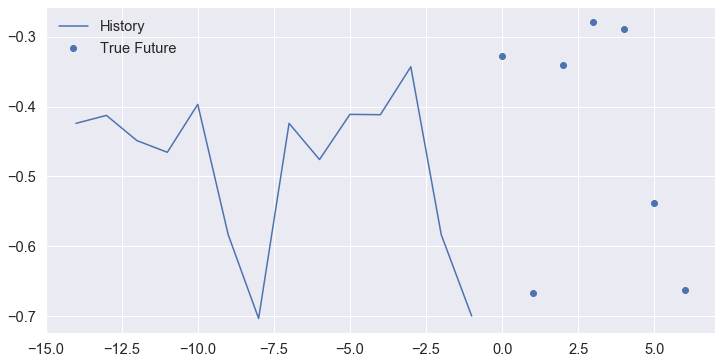

In [35]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

### Training

In [36]:
print(f"nb samples for training : {x_train_multi.shape[0]}")
print(f"nb samples for validation : {x_val_multi.shape[0]}")

nb samples for training : 99
nb samples for validation : 7



 Run #0
Restoring model weights from the end of the best epoch.
Epoch 00940: early stopping
Run #0 : val_loss = 1.271128535270691


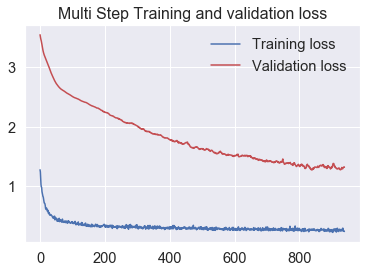

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #1
Restoring model weights from the end of the best epoch.
Epoch 00954: early stopping
Run #1 : val_loss = 1.4120179414749146

 Run #2
Restoring model weights from the end of the best epoch.
Epoch 01371: early stopping
Run #2 : val_loss = 1.0466690063476562


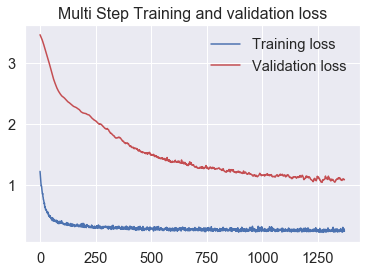

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #3
Restoring model weights from the end of the best epoch.
Epoch 01103: early stopping
Run #3 : val_loss = 1.3654882907867432

 Run #4
Restoring model weights from the end of the best epoch.
Epoch 01161: early stopping
Run #4 : val_loss = 1.205754280090332

 Run #5
Restoring model weights from the end of the best epoch.
Epoch 00976: early stopping
Run #5 : val_loss = 1.2696541547775269

 Run #6
Restoring model weights from the end of the best epoch.
Epoch 00986: early stopping
Run #6 : val_loss = 1.2052780389785767

 Run #7
Restoring model weights from the end of the best epoch.
Epoch 01231: early stopping
Run #7 : val_loss = 1.1151028871536255

 Run #8
Restoring model weights from the end of the best epoch.
Epoch 00955: early stopping
Run #8 : val_loss = 1.2818177938461304

 Run #9
Restoring model weights from the end of the best epoch.
Epoch 00785: early stopping
Run #9 : val_loss = 1.2751296758651733

 Run #10
R

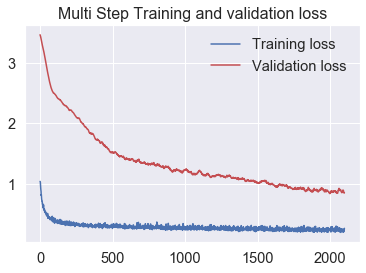

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #15
Restoring model weights from the end of the best epoch.
Epoch 01133: early stopping
Run #15 : val_loss = 1.4461511373519897

 Run #16
Restoring model weights from the end of the best epoch.
Epoch 00962: early stopping
Run #16 : val_loss = 1.2878543138504028

 Run #17
Restoring model weights from the end of the best epoch.
Epoch 00947: early stopping
Run #17 : val_loss = 1.2796134948730469

 Run #18
Restoring model weights from the end of the best epoch.
Epoch 01033: early stopping
Run #18 : val_loss = 1.3402260541915894

 Run #19
Restoring model weights from the end of the best epoch.
Epoch 00855: early stopping
Run #19 : val_loss = 1.3492478132247925

 Run #20
Restoring model weights from the end of the best epoch.
Epoch 00899: early stopping
Run #20 : val_loss = 1.3726041316986084

 Run #21
Restoring model weights from the end of the best epoch.
Epoch 00921: early stopping
Run #21 : val_loss = 1.3411462306976

Restoring model weights from the end of the best epoch.
Epoch 02140: early stopping
Run #76 : val_loss = 0.7987766861915588


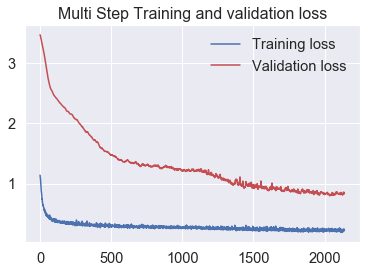

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #77
Restoring model weights from the end of the best epoch.
Epoch 01200: early stopping
Run #77 : val_loss = 1.2501376867294312

 Run #78
Restoring model weights from the end of the best epoch.
Epoch 00913: early stopping
Run #78 : val_loss = 1.3062185049057007

 Run #79
Restoring model weights from the end of the best epoch.
Epoch 01127: early stopping
Run #79 : val_loss = 1.2216434478759766

 Run #80
Restoring model weights from the end of the best epoch.
Epoch 00934: early stopping
Run #80 : val_loss = 1.2088526487350464

 Run #81
Restoring model weights from the end of the best epoch.
Epoch 01323: early stopping
Run #81 : val_loss = 1.2918399572372437

 Run #82
Restoring model weights from the end of the best epoch.
Epoch 01051: early stopping
Run #82 : val_loss = 1.1902294158935547

 Run #83
Restoring model weights from the end of the best epoch.
Epoch 01922: early stopping
Run #83 : val_loss = 0.9514650702476

Restoring model weights from the end of the best epoch.
Epoch 01082: early stopping
Run #138 : val_loss = 1.349597692489624

 Run #139
Restoring model weights from the end of the best epoch.
Epoch 01707: early stopping
Run #139 : val_loss = 0.986205518245697

 Run #140
Restoring model weights from the end of the best epoch.
Epoch 00832: early stopping
Run #140 : val_loss = 1.3768396377563477

 Run #141
Restoring model weights from the end of the best epoch.
Epoch 00939: early stopping
Run #141 : val_loss = 1.3810011148452759

 Run #142
Restoring model weights from the end of the best epoch.
Epoch 01842: early stopping
Run #142 : val_loss = 0.9604668617248535

 Run #143
Restoring model weights from the end of the best epoch.
Epoch 00990: early stopping
Run #143 : val_loss = 1.3979460000991821

 Run #144
Restoring model weights from the end of the best epoch.
Epoch 00919: early stopping
Run #144 : val_loss = 1.3759663105010986

 Run #145
Restoring model weights from the end of the best e

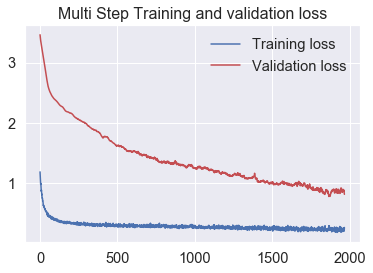

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #154
Restoring model weights from the end of the best epoch.
Epoch 01023: early stopping
Run #154 : val_loss = 1.3195769786834717

 Run #155
Restoring model weights from the end of the best epoch.
Epoch 01105: early stopping
Run #155 : val_loss = 1.3044065237045288

 Run #156
Restoring model weights from the end of the best epoch.
Epoch 00864: early stopping
Run #156 : val_loss = 1.4500325918197632

 Run #157
Restoring model weights from the end of the best epoch.
Epoch 01480: early stopping
Run #157 : val_loss = 1.1037323474884033

 Run #158
Restoring model weights from the end of the best epoch.
Epoch 01367: early stopping
Run #158 : val_loss = 1.0547888278961182

 Run #159
Restoring model weights from the end of the best epoch.
Epoch 01221: early stopping
Run #159 : val_loss = 1.302063226699829

 Run #160
Restoring model weights from the end of the best epoch.
Epoch 00858: early stopping
Run #160 : val_loss = 1.

Restoring model weights from the end of the best epoch.
Epoch 00705: early stopping
Run #214 : val_loss = 1.4049255847930908

 Run #215
Restoring model weights from the end of the best epoch.
Epoch 00909: early stopping
Run #215 : val_loss = 1.414541482925415

 Run #216
Restoring model weights from the end of the best epoch.
Epoch 00900: early stopping
Run #216 : val_loss = 1.3601888418197632

 Run #217
Restoring model weights from the end of the best epoch.
Epoch 00805: early stopping
Run #217 : val_loss = 1.3111988306045532

 Run #218
Restoring model weights from the end of the best epoch.
Epoch 01659: early stopping
Run #218 : val_loss = 0.9387328028678894

 Run #219
Restoring model weights from the end of the best epoch.
Epoch 01238: early stopping
Run #219 : val_loss = 1.27121901512146

 Run #220
Restoring model weights from the end of the best epoch.
Epoch 02069: early stopping
Run #220 : val_loss = 0.8606423139572144

 Run #221
Restoring model weights from the end of the best ep

Restoring model weights from the end of the best epoch.
Epoch 02740: early stopping
Run #275 : val_loss = 0.8261675238609314

 Run #276
Restoring model weights from the end of the best epoch.
Epoch 00809: early stopping
Run #276 : val_loss = 1.3866050243377686

 Run #277
Restoring model weights from the end of the best epoch.
Epoch 00981: early stopping
Run #277 : val_loss = 1.2306963205337524

 Run #278
Restoring model weights from the end of the best epoch.
Epoch 00667: early stopping
Run #278 : val_loss = 1.4853485822677612

 Run #279
Restoring model weights from the end of the best epoch.
Epoch 01137: early stopping
Run #279 : val_loss = 1.26343834400177

 Run #280
Restoring model weights from the end of the best epoch.
Epoch 01070: early stopping
Run #280 : val_loss = 1.1992777585983276

 Run #281
Restoring model weights from the end of the best epoch.
Epoch 01130: early stopping
Run #281 : val_loss = 1.2331678867340088

 Run #282
Restoring model weights from the end of the best e

Restoring model weights from the end of the best epoch.
Epoch 00971: early stopping
Run #336 : val_loss = 1.2700555324554443

 Run #337
Restoring model weights from the end of the best epoch.
Epoch 01173: early stopping
Run #337 : val_loss = 1.227038025856018

 Run #338
Restoring model weights from the end of the best epoch.
Epoch 01515: early stopping
Run #338 : val_loss = 1.0572224855422974

 Run #339
Restoring model weights from the end of the best epoch.
Epoch 00822: early stopping
Run #339 : val_loss = 1.3313007354736328

 Run #340
Restoring model weights from the end of the best epoch.
Epoch 01554: early stopping
Run #340 : val_loss = 0.9589396715164185

 Run #341
Restoring model weights from the end of the best epoch.
Epoch 00964: early stopping
Run #341 : val_loss = 1.2664533853530884

 Run #342
Restoring model weights from the end of the best epoch.
Epoch 01077: early stopping
Run #342 : val_loss = 1.2240113019943237

 Run #343
Restoring model weights from the end of the best 

Restoring model weights from the end of the best epoch.
Epoch 00831: early stopping
Run #397 : val_loss = 1.383860468864441

 Run #398
Restoring model weights from the end of the best epoch.
Epoch 01506: early stopping
Run #398 : val_loss = 1.15396249294281

 Run #399
Restoring model weights from the end of the best epoch.
Epoch 01687: early stopping
Run #399 : val_loss = 0.9405873417854309

 Run #400
Restoring model weights from the end of the best epoch.
Epoch 00883: early stopping
Run #400 : val_loss = 1.341196060180664

 Run #401
Restoring model weights from the end of the best epoch.
Epoch 01167: early stopping
Run #401 : val_loss = 1.2443504333496094

 Run #402
Restoring model weights from the end of the best epoch.
Epoch 01376: early stopping
Run #402 : val_loss = 1.2198333740234375

 Run #403
Restoring model weights from the end of the best epoch.
Epoch 01895: early stopping
Run #403 : val_loss = 0.9495405554771423

 Run #404
Restoring model weights from the end of the best epo

Restoring model weights from the end of the best epoch.
Epoch 00885: early stopping
Run #458 : val_loss = 1.284515380859375

 Run #459
Restoring model weights from the end of the best epoch.
Epoch 01314: early stopping
Run #459 : val_loss = 1.0560787916183472

 Run #460
Restoring model weights from the end of the best epoch.
Epoch 01105: early stopping
Run #460 : val_loss = 1.1387929916381836

 Run #461
Restoring model weights from the end of the best epoch.
Epoch 01499: early stopping
Run #461 : val_loss = 1.0243360996246338

 Run #462
Restoring model weights from the end of the best epoch.
Epoch 01024: early stopping
Run #462 : val_loss = 1.2926262617111206

 Run #463
Restoring model weights from the end of the best epoch.
Epoch 00910: early stopping
Run #463 : val_loss = 1.3502752780914307

 Run #464
Restoring model weights from the end of the best epoch.
Epoch 01282: early stopping
Run #464 : val_loss = 1.1285650730133057

 Run #465
Restoring model weights from the end of the best 

Restoring model weights from the end of the best epoch.
Epoch 01109: early stopping
Run #519 : val_loss = 1.3157373666763306

 Run #520
Restoring model weights from the end of the best epoch.
Epoch 01218: early stopping
Run #520 : val_loss = 0.9881475567817688

 Run #521
Restoring model weights from the end of the best epoch.
Epoch 01096: early stopping
Run #521 : val_loss = 1.2424077987670898

 Run #522
Restoring model weights from the end of the best epoch.
Epoch 01525: early stopping
Run #522 : val_loss = 1.035304069519043

 Run #523
Restoring model weights from the end of the best epoch.
Epoch 01122: early stopping
Run #523 : val_loss = 1.1607061624526978

 Run #524
Restoring model weights from the end of the best epoch.
Epoch 00935: early stopping
Run #524 : val_loss = 1.3272117376327515

 Run #525
Restoring model weights from the end of the best epoch.
Epoch 01414: early stopping
Run #525 : val_loss = 1.0204273462295532

 Run #526
Restoring model weights from the end of the best 

Restoring model weights from the end of the best epoch.
Epoch 01196: early stopping
Run #580 : val_loss = 1.1860817670822144

 Run #581
Restoring model weights from the end of the best epoch.
Epoch 01169: early stopping
Run #581 : val_loss = 1.213784098625183

 Run #582
Restoring model weights from the end of the best epoch.
Epoch 00619: early stopping
Run #582 : val_loss = 1.5001496076583862

 Run #583
Restoring model weights from the end of the best epoch.
Epoch 01353: early stopping
Run #583 : val_loss = 1.059506893157959

 Run #584
Restoring model weights from the end of the best epoch.
Epoch 00954: early stopping
Run #584 : val_loss = 1.3152978420257568

 Run #585
Restoring model weights from the end of the best epoch.
Epoch 00852: early stopping
Run #585 : val_loss = 1.3032944202423096

 Run #586
Restoring model weights from the end of the best epoch.
Epoch 01356: early stopping
Run #586 : val_loss = 0.9538148641586304

 Run #587
Restoring model weights from the end of the best e

Restoring model weights from the end of the best epoch.
Epoch 01646: early stopping
Run #641 : val_loss = 0.8664202094078064

 Run #642
Restoring model weights from the end of the best epoch.
Epoch 01352: early stopping
Run #642 : val_loss = 0.9760826826095581

 Run #643
Restoring model weights from the end of the best epoch.
Epoch 01205: early stopping
Run #643 : val_loss = 1.2285507917404175

 Run #644
Restoring model weights from the end of the best epoch.
Epoch 01132: early stopping
Run #644 : val_loss = 1.2469755411148071

 Run #645
Restoring model weights from the end of the best epoch.
Epoch 01010: early stopping
Run #645 : val_loss = 1.2865418195724487

 Run #646
Restoring model weights from the end of the best epoch.
Epoch 01821: early stopping
Run #646 : val_loss = 0.8834125399589539

 Run #647
Restoring model weights from the end of the best epoch.
Epoch 01287: early stopping
Run #647 : val_loss = 1.0979043245315552

 Run #648
Restoring model weights from the end of the best

Restoring model weights from the end of the best epoch.
Epoch 00808: early stopping
Run #702 : val_loss = 1.368293046951294

 Run #703
Restoring model weights from the end of the best epoch.
Epoch 01108: early stopping
Run #703 : val_loss = 1.2817628383636475

 Run #704
Restoring model weights from the end of the best epoch.
Epoch 01605: early stopping
Run #704 : val_loss = 0.8964493870735168

 Run #705
Restoring model weights from the end of the best epoch.
Epoch 01349: early stopping
Run #705 : val_loss = 1.2533318996429443

 Run #706
Restoring model weights from the end of the best epoch.
Epoch 00890: early stopping
Run #706 : val_loss = 1.2137621641159058

 Run #707
Restoring model weights from the end of the best epoch.
Epoch 00810: early stopping
Run #707 : val_loss = 1.3848841190338135

 Run #708
Restoring model weights from the end of the best epoch.
Epoch 01277: early stopping
Run #708 : val_loss = 1.2660897970199585

 Run #709
Restoring model weights from the end of the best 

Restoring model weights from the end of the best epoch.
Epoch 01097: early stopping
Run #763 : val_loss = 1.2220525741577148

 Run #764
Restoring model weights from the end of the best epoch.
Epoch 00812: early stopping
Run #764 : val_loss = 1.4116684198379517

 Run #765
Restoring model weights from the end of the best epoch.
Epoch 01123: early stopping
Run #765 : val_loss = 1.3486682176589966

 Run #766
Restoring model weights from the end of the best epoch.
Epoch 00962: early stopping
Run #766 : val_loss = 1.3544178009033203

 Run #767
Restoring model weights from the end of the best epoch.
Epoch 01143: early stopping
Run #767 : val_loss = 1.066902995109558

 Run #768
Restoring model weights from the end of the best epoch.
Epoch 01867: early stopping
Run #768 : val_loss = 1.0413058996200562

 Run #769
Restoring model weights from the end of the best epoch.
Epoch 01428: early stopping
Run #769 : val_loss = 1.0008090734481812

 Run #770
Restoring model weights from the end of the best 

Restoring model weights from the end of the best epoch.
Epoch 01000: early stopping
Run #824 : val_loss = 1.1752474308013916

 Run #825
Restoring model weights from the end of the best epoch.
Epoch 01109: early stopping
Run #825 : val_loss = 1.2960585355758667

 Run #826
Restoring model weights from the end of the best epoch.
Epoch 01442: early stopping
Run #826 : val_loss = 0.9837074279785156

 Run #827
Restoring model weights from the end of the best epoch.
Epoch 00936: early stopping
Run #827 : val_loss = 1.3661253452301025

 Run #828
Restoring model weights from the end of the best epoch.
Epoch 00600: early stopping
Run #828 : val_loss = 1.4674290418624878

 Run #829
Restoring model weights from the end of the best epoch.
Epoch 01353: early stopping
Run #829 : val_loss = 1.0647555589675903

 Run #830
Restoring model weights from the end of the best epoch.
Epoch 01099: early stopping
Run #830 : val_loss = 1.3864057064056396

 Run #831
Restoring model weights from the end of the best

Restoring model weights from the end of the best epoch.
Epoch 01524: early stopping
Run #885 : val_loss = 1.0365946292877197

 Run #886
Restoring model weights from the end of the best epoch.
Epoch 01480: early stopping
Run #886 : val_loss = 1.0813344717025757

 Run #887
Restoring model weights from the end of the best epoch.
Epoch 01166: early stopping
Run #887 : val_loss = 1.132621169090271

 Run #888
Restoring model weights from the end of the best epoch.
Epoch 01148: early stopping
Run #888 : val_loss = 1.0880329608917236

 Run #889
Restoring model weights from the end of the best epoch.
Epoch 01751: early stopping
Run #889 : val_loss = 1.0847874879837036

 Run #890
Restoring model weights from the end of the best epoch.
Epoch 01707: early stopping
Run #890 : val_loss = 0.798905074596405

 Run #891
Restoring model weights from the end of the best epoch.
Epoch 01146: early stopping
Run #891 : val_loss = 1.3664408922195435

 Run #892
Restoring model weights from the end of the best e

Restoring model weights from the end of the best epoch.
Epoch 01643: early stopping
Run #946 : val_loss = 0.8507146835327148

 Run #947
Restoring model weights from the end of the best epoch.
Epoch 01271: early stopping
Run #947 : val_loss = 1.1569554805755615

 Run #948
Restoring model weights from the end of the best epoch.
Epoch 01488: early stopping
Run #948 : val_loss = 1.252460241317749

 Run #949
Restoring model weights from the end of the best epoch.
Epoch 01758: early stopping
Run #949 : val_loss = 0.9259069561958313

 Run #950
Restoring model weights from the end of the best epoch.
Epoch 00854: early stopping
Run #950 : val_loss = 1.3289974927902222

 Run #951
Restoring model weights from the end of the best epoch.
Epoch 01012: early stopping
Run #951 : val_loss = 1.31304132938385

 Run #952
Restoring model weights from the end of the best epoch.
Epoch 01154: early stopping
Run #952 : val_loss = 1.3228075504302979

 Run #953
Restoring model weights from the end of the best ep

In [37]:
%%time
'''
Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
'''
NB_TRY = 1000
EVALUATION_INTERVAL = 1
EPOCHS = 5000

# Hyper-parameters
# lr=6e-2 : err=1.23 mais diverge
# lr=1e-2 : err=1.22 mais pas eu le temps de converger (1 seul train)
# lr=0.5e-2 : err=1.29 mais pas eu le temps de converger (1 seul train)
# lr=2e-2 : err=1.18 Final val_loss = 1.181 people : 321 (juil 2020)
# lr=2e-2 : err= 1.83 Mean asbolute Error in people : 484 (aout 2020)
# lr=2e-2 : Final val_loss = 1.7202385663986206 / 453.984980383009 / 45min 10s / mid-august
# lr=2e-2 : Final val_loss = 5.082364559173584 Mean asbolute Error in people : 1540.5864920799772
# lr=2e-2 : Final val_loss = 4.183023452758789 Mean asbolute Error in people : 1630.9316293070544 Wall time: 2h 23min 11s
lr = 2e-2
decay = 1e-6 #1e-6
momentum = 0.9 # 0.9
nesterov = True # True
patience = 100 # 30

list_loss_multi = []

for I in range(NB_TRY):
    print("")
    print(f" Run #{I}")
    
    tf.keras.backend.clear_session()
    # optimizer def 
    sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
                          nesterov=nesterov)

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                   verbose=1, patience=patience,
                                   restore_best_weights=True)
    # create model
    multi_step_model = tf.keras.models.Sequential()
    multi_step_model.add(tf.keras.layers.LSTM(features.shape[1], 
                                              return_sequences=False,
                                        input_shape=x_train_multi.shape[-2:]))
    multi_step_model.add(tf.keras.layers.Dropout(0.2))
    multi_step_model.add(tf.keras.layers.BatchNormalization())
    multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
    # compile
    multi_step_model.compile(optimizer=sgd_2, loss='mae')
    # fitting
    multi_step_history = multi_step_model.fit(train_data_multi, 
                                            epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_multi,
                                            validation_steps=1,
                                            callbacks=[es],
                                            verbose=0)
    # eval
    mae_curr = np.min(multi_step_history.history['val_loss'])
    
    if (I == 0):
        list_loss_multi.append(mae_curr)
        
    # find the best model
    print(f"Run #{I} : val_loss = {mae_curr}")
    if (mae_curr < np.min(list_loss_multi)) | (I == 0):
        # plot history
        plot_train_history(multi_step_history,
                   'Multi Step Training and validation loss')
        # save
        if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
            os.mkdir(PATH_MDL_MULTI_STEP)
        multi_step_model.save(PATH_MDL_MULTI_STEP)
        
    if (I != 0):   
        list_loss_multi.append(mae_curr)
    
print(" ")
print(f"Final val_loss = {np.min(list_loss_multi)}")
print("Mean asbolute Error in people :",
      data_std[4] * np.min(list_loss_multi))
print(" ")


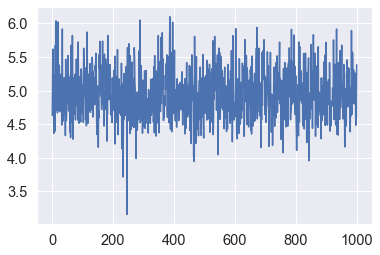

In [104]:
plt.plot(list_loss_multi)

### Eval

In [18]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1a443144d0> and <tensorflow.python.keras.layers.core.Dropout object at 0x1a44386350>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1a44356610> and <tensorflow.python.keras.layers.core.Dense object at 0x1a44397190>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1a44356610> and <tensorflow.python.keras.layers.core.Dropout object at 0x1a44386350>).
CPU times: user 2.22 s, sys: 230 ms, total: 2.45 s
Wall time: 2.59 s


In [19]:
%%time
y_val_multi_pred = multi_step_model.predict(x_val_multi)
data_std[4] * mean_absolute_error(y_val_multi, y_val_multi_pred)

CPU times: user 655 ms, sys: 51.9 ms, total: 707 ms
Wall time: 841 ms


1572.7315027532386

In [20]:
multi_step_model.predict(x_val_multi)

array([[2.9746983, 3.1116686, 2.5875185, 1.2422215, 2.0241418, 4.9832687,
        4.285879 ],
       [2.58168  , 1.4381961, 2.1844146, 2.9205248, 3.8819315, 4.4657717,
        4.219105 ],
       [1.828082 , 1.0000149, 3.0118008, 4.1426096, 4.1371245, 4.1796017,
        4.5154877],
       [1.0354276, 3.0471642, 4.2049894, 4.411288 , 4.494838 , 4.0867577,
        1.8638455],
       [3.6870515, 3.8279164, 3.6582677, 4.6333137, 4.215897 , 1.0776592,
        0.9121251],
       [3.6522832, 3.1979456, 4.475068 , 4.194608 , 1.3043671, 1.1235622,
        4.7743382],
       [3.1954746, 4.2069793, 4.0742545, 1.5313483, 0.5984289, 4.5732994,
        5.073973 ]], dtype=float32)

In [21]:
y_val_multi_pred.shape[0]

7

In [22]:
val_data_multi

<RepeatDataset shapes: ((None, 14, 9), (None, 7)), types: (tf.float64, tf.float64)>

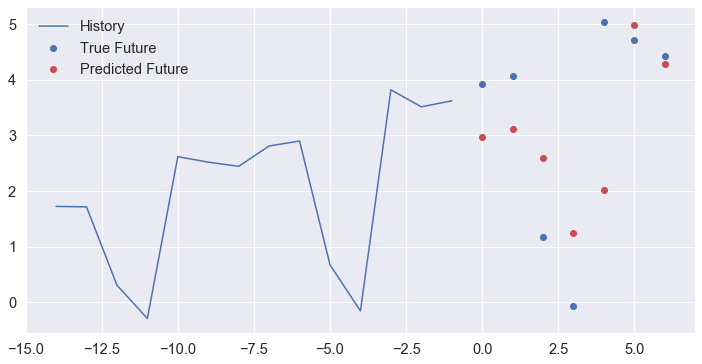

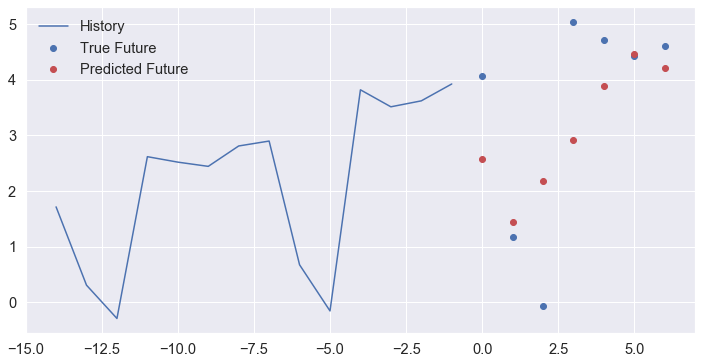

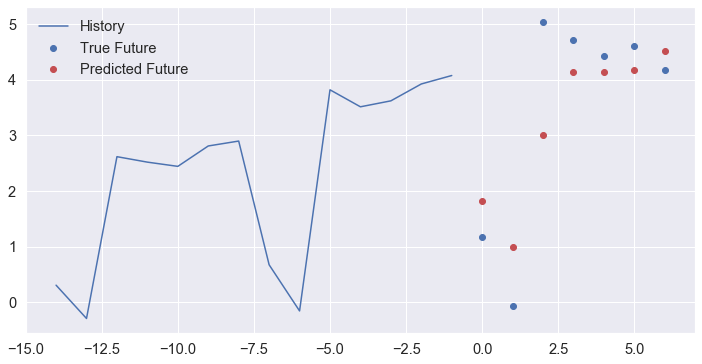

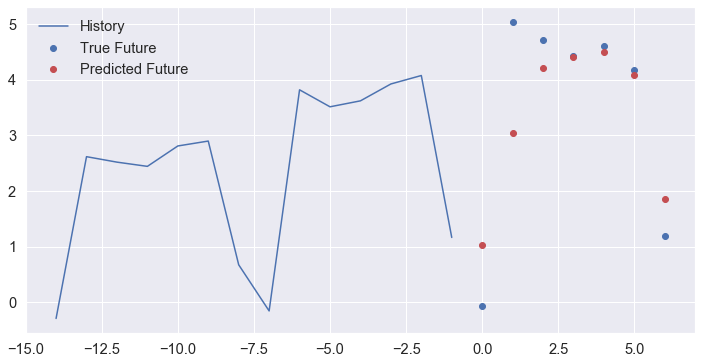

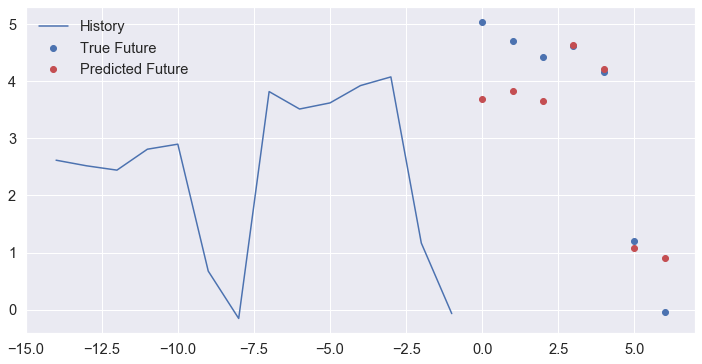

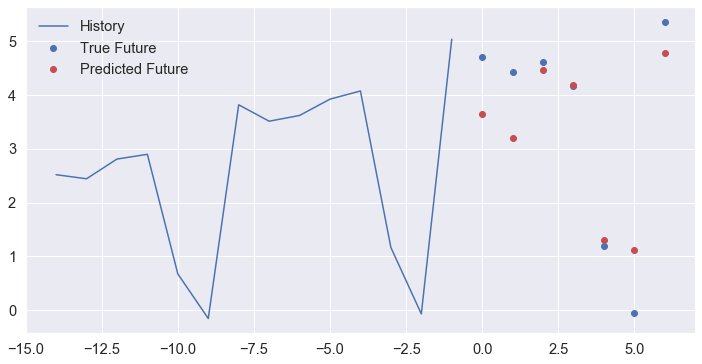

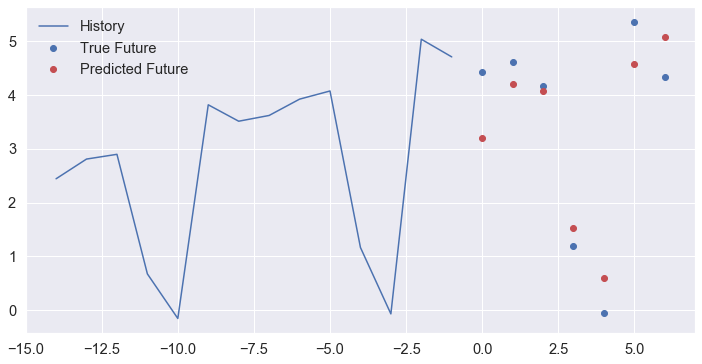

In [25]:
'''for x, y in val_data_single.take(1):
    for I in range(12):
        plot = show_plot([x[I][:, 4].numpy(), y[I].numpy(),
                        multi_step_model.predict(x)[I]], 3,
                       'Multi Step Prediction')
        plot.show()'''



for x, y in val_data_multi.take(1):
    for I in range(y_val_multi_pred.shape[0]):
        multi_step_plot(x[I], y[I], multi_step_model.predict(x)[I])

### Final Prediction

In [26]:
PATH_MDL_MULTI_STEP

'./mdl_multi_step_pos_fr'

In [27]:
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1a463274d0> and <tensorflow.python.keras.layers.core.Dropout object at 0x1a463305d0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1a46330e50> and <tensorflow.python.keras.layers.core.Dense object at 0x1a463393d0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1a46330e50> and <tensorflow.python.keras.layers.core.Dropout object at 0x1a463305d0>).


In [28]:
# reload data
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]
# prepare features
features = df_feat_fr.copy().filter(items=['T_min', 'T_max', 'H_min',
                                           'H_max', 'pos', 'test', 'day_num',
                                          'age_pos', 'age_test'])
# calculate mean & std 
#TRAIN_SPLIT = 93
# prepare dataset
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

In [29]:
%%time
# prepare data : very last days
x_multi = np.array([dataset[-PAST_HISTORY:,:]]) 
# predict next days
y_multi_pred = multi_step_model.predict(x_multi)
y_multi_pred

# convert in positive cases
y_pos_pred = y_multi_pred * data_std[4] + data_mean[4]


CPU times: user 647 ms, sys: 45.8 ms, total: 693 ms
Wall time: 780 ms


In [30]:
dataset[-PAST_HISTORY:,4] * data_std[4] + data_mean[4]

array([ 9482.,  9790.,  3890.,  1386., 11741., 11075., 10491., 10871.,
        9980.,  3956.,  1434., 12392., 10315.,  8967.])

In [31]:
y_pos_pred

array([[ 7405.1035,  6717.069 ,  7041.5317,  6298.325 ,  8722.111 ,
        12616.227 , 10054.41  ]], dtype=float32)

In [32]:
'''%%time
# prepare data : very last days
x_multi = np.array([dataset[-PAST_HISTORY-3*FUTURE_TARGET:-3*FUTURE_TARGET,:]]) 
# predict next days
y_multi_pred = multi_step_model.predict(x_multi)
y_multi_pred

# convert in positive cases
y_pos_pred = y_multi_pred * data_std[4] + data_mean[4]'''
#

'%%time\n# prepare data : very last days\nx_multi = np.array([dataset[-PAST_HISTORY-3*FUTURE_TARGET:-3*FUTURE_TARGET,:]]) \n# predict next days\ny_multi_pred = multi_step_model.predict(x_multi)\ny_multi_pred\n\n# convert in positive cases\ny_pos_pred = y_multi_pred * data_std[4] + data_mean[4]'

In [33]:
#dataset[-PAST_HISTORY-FUTURE_TARGET:,4] * data_std[4] + data_mean[4]

In [34]:
#y_pos_pred

In [35]:
df_feat_fr.date.max()

'2020-09-16'

In [36]:
df_feat_fr.pos.std()

3114.322481686026

In [37]:
data_std[4]

2026.7034092488736

In [38]:
# last nth days

str_date_0 = add_days(df_feat_fr.date.max(), -NB_DAY_PLOT)
df_plot = df_feat_fr[df_feat_fr["date"] >= str_date_0].copy()

# add pos pred next days from last day : date, pos, total (sum)
str_date_pred_0 = df_feat_fr.date.max()
str_date_pred_1 = add_days(str_date_pred_0, FUTURE_TARGET)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
# figure 
df_plot_pred = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred["pos"] = y_pos_pred[0].astype(int)
arr_nb_pred = df_plot_pred["pos"].cumsum().values
df_plot_pred["nb_cases"] = df_plot["nb_cases"].max() + arr_nb_pred
    
df_plot_pred

,date,pos,nb_cases
2020-09-17,2020-09-17,7405,436107
2020-09-18,2020-09-18,6717,442824
2020-09-19,2020-09-19,7041,449865
2020-09-20,2020-09-20,6298,456163
2020-09-21,2020-09-21,8722,464885
2020-09-22,2020-09-22,12616,477501
2020-09-23,2020-09-23,10054,487555


In [39]:
df_feat_fr.iloc[TRAIN_SPLIT]["date"]

'2020-09-03'

In [40]:
df_plot

,date,T_min,T_max,H_min,H_max,pos,age_pos,test,age_test,day_num,nb_cases
date,,,,,,,,,,,
2020-07-15,2020-07-15,289.575000,295.250000,58.423729,85.491525,838,45.352029,71683,46.724635,3,174158
2020-07-16,2020-07-16,289.458333,295.160000,63.016949,85.898305,963,43.357217,76004,46.855929,4,175121
2020-07-17,2020-07-17,289.601667,296.803333,55.779661,87.033898,944,45.911017,84930,47.651348,5,176065
2020-07-18,2020-07-18,288.835000,298.701667,47.655172,87.362069,439,43.138952,36632,47.723357,6,176504
2020-07-19,2020-07-19,288.620000,299.983333,44.206897,84.879310,187,44.946524,10557,51.024155,0,176691
...,...,...,...,...,...,...,...,...,...,...,...
2020-09-12,2020-09-12,287.893333,298.625000,46.627119,87.322034,3956,42.223205,79543,42.087248,6,395594
2020-09-13,2020-09-13,287.946667,300.263333,44.762712,86.593220,1434,43.935146,22292,44.271802,0,397028
2020-09-14,2020-09-14,289.485000,302.236667,42.203390,82.067797,12392,42.094819,202533,42.523465,1,409420


In [41]:
#df_plot.iloc[TRAIN_SPLIT]["date"]

### Figure

In [44]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Create and style traces
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total cases"),
             secondary_y=False)

fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total predicted"),
             secondary_y=False)
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="New cases"), 
             secondary_y=True)

fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="New predicted"), 
            secondary_y=True)
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France with prediction</b><br>' + \
    'LMST Deep Learning Model : ' + \
    'prediction of <b>{} days</b>'.format(FUTURE_TARGET) + \
    ' from <b>last {} days</b>'.format(PAST_HISTORY) + \
    '<br>Trained until ' + df_feat_fr.iloc[TRAIN_SPLIT]["date"]

fig.update_layout(title=title_fig,
                   yaxis_title='nb confirmed cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))

fig.update_yaxes(title_text="daily cases", range=[0, 13000], secondary_y=True)

fig.show()


### Predict all past

In [45]:
%%time
# prepare list of past histories
list_x = []
# prepare data : very last days
nb_max = math.ceil((NB_DAY_PLOT)/FUTURE_TARGET)
I_start_pred = TRAIN_SPLIT - nb_max*FUTURE_TARGET
for I in range(nb_max):
    I_start = I_start_pred + I * FUTURE_TARGET - PAST_HISTORY
    I_end =   I_start_pred + I * FUTURE_TARGET
    print(f"[{I_start} - {I_end}]")
    list_x.append(np.array([dataset[I_start:I_end, :]]))
print(len(list_x))
# predict
for I, x_multi in enumerate(list_x):
    if I:
        y_multi_pred = np.concatenate([y_multi_pred, 
            multi_step_model.predict(x_multi)], axis=1)
    else:
        y_multi_pred = multi_step_model.predict(x_multi)   
# convert in positive cases
y_pos_pred = (y_multi_pred * data_std[4]) + data_mean[4] 
y_pos_pred

[36 - 50]
[43 - 57]
[50 - 64]
[57 - 71]
[64 - 78]
[71 - 85]
[78 - 92]
[85 - 99]
[92 - 106]
9
CPU times: user 389 ms, sys: 26.2 ms, total: 416 ms
Wall time: 430 ms


array([[ 845.48706,  538.0779 ,  351.56384,  383.92432,  503.88574,
         481.9204 ,  729.92584,  716.94543,  588.76483,  386.4453 ,
         333.3119 ,  561.6996 ,  716.2637 ,  776.74713,  891.563  ,
         790.8907 ,  616.6542 ,  468.875  ,  612.5656 ,  870.15875,
         990.31555, 1075.0419 ,  995.14417,  854.65186,  613.56726,
         857.7212 , 1441.4237 , 1497.2423 , 1504.7167 , 1263.327  ,
        1087.1573 ,  864.19995, 1266.2051 , 1995.6448 , 2120.5154 ,
        1986.829  , 2111.6436 , 1387.7213 ,  803.8506 , 1630.4735 ,
        2984.4312 , 2655.44   , 2738.1348 , 2842.0684 , 2179.4397 ,
        1596.631  , 3015.3584 , 5089.9375 , 4149.332  , 4719.6855 ,
        4032.9382 , 3066.115  , 2817.296  , 4875.4136 , 6880.008  ,
        5977.1714 , 6291.6553 , 5571.298  , 4520.0215 , 3554.4827 ,
        5736.5645 , 9341.373  , 8341.269  ]], dtype=float32)

In [47]:
# create df out prediction
K_days = y_pos_pred.shape[1]
str_date_pred_1 = df_feat_fr.date.max()
str_date_pred_0 = add_days(str_date_pred_1, -1*K_days)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
print(len(list_dates_pred))
print(str_date_pred_0)
print(str_date_pred_1)

df_plot_pred_all = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred_all["pos"] = y_pos_pred[0].astype(int)

list_nb_cases =[]
str_date_nb_0 = str_date_pred_0
for I in range(0, df_plot_pred_all["pos"].shape[0], FUTURE_TARGET):
    str_date_nb_0 = add_days(str_date_pred_0, I)
    nb_0 = df_feat_fr[df_feat_fr["date"] == str_date_nb_0]["nb_cases"][0]
    arr_nb = nb_0 + \
        df_plot_pred_all.iloc[I:I+FUTURE_TARGET]["pos"].cumsum().values
    list_nb_cases = list_nb_cases + arr_nb.tolist()
df_plot_pred_all["nb_cases"] = list_nb_cases


df_plot_pred_all

63
2020-07-15
2020-09-16


,date,pos,nb_cases
2020-07-16,2020-07-16,845,175003
2020-07-17,2020-07-17,538,175541
2020-07-18,2020-07-18,351,175892
2020-07-19,2020-07-19,383,176275
2020-07-20,2020-07-20,503,176778
...,...,...,...
2020-09-12,2020-09-12,4520,387169
2020-09-13,2020-09-13,3554,390723
2020-09-14,2020-09-14,5736,396459
2020-09-15,2020-09-15,9341,405800


In [48]:
add_days(str_date_pred_0, 0)

'2020-07-15'

In [49]:
str_date_pred_0

'2020-07-15'

In [50]:
df_plot_pred_all.iloc[I:I+FUTURE_TARGET]["pos"].cumsum().values +1

array([ 6292, 11863, 16383, 19937, 25673, 35014, 43355])

In [51]:
'''# create df out prediction
K_days = y_pos_pred.shape[1]
str_date_pred_1 = df_feat_fr.date.max()
str_date_pred_0 = add_days(str_date_pred_1, -1*K_days)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
print(len(list_dates_pred))
print(str_date_pred_0)
print(str_date_pred_1)

df_plot_pred_all = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred_all["pos"] = y_pos_pred[0].astype(int)
arr_nb_pred = df_plot_pred_all["pos"].cumsum().values
df_plot_pred_all["nb_cases"] = df_feat_fr[df_feat_fr["date"] == \
    str_date_pred_0]["nb_cases"][0] + arr_nb_pred


df_plot_pred_all'''

'# create df out prediction\nK_days = y_pos_pred.shape[1]\nstr_date_pred_1 = df_feat_fr.date.max()\nstr_date_pred_0 = add_days(str_date_pred_1, -1*K_days)\nlist_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)\nprint(len(list_dates_pred))\nprint(str_date_pred_0)\nprint(str_date_pred_1)\n\ndf_plot_pred_all = pd.DataFrame(index=list_dates_pred, columns=["date"], \n                       data=list_dates_pred)\n\ndf_plot_pred_all["pos"] = y_pos_pred[0].astype(int)\narr_nb_pred = df_plot_pred_all["pos"].cumsum().values\ndf_plot_pred_all["nb_cases"] = df_feat_fr[df_feat_fr["date"] ==     str_date_pred_0]["nb_cases"][0] + arr_nb_pred\n\n\ndf_plot_pred_all'

### Figure all past 

In [52]:
str_date_mdl =  df_feat_fr.iloc[TRAIN_SPLIT]["date"]

In [54]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Create and style traces
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="Daily", opacity=0.5), 
             secondary_y=True)
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total"),
             secondary_y=False)

fig.add_trace(go.Scatter(x=df_plot_pred_all["date"].astype(np.datetime64), 
                         y=df_plot_pred_all["nb_cases"],
                    mode='lines+markers',
                    line_shape='hv',
                    connectgaps=True, name="Total (estim.)"),
             secondary_y=False)

fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='hv',
                    connectgaps=True, name="Total (future estim.)"),
             secondary_y=False)


fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="Daily (future estim.)", opacity=0.5), 
            secondary_y=True)

# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France</b>' + \
    '<br>Model trained until <b>' + str_date_mdl + '</b>' + \
    '<br>predicts next {} days with last {} days until <b>' \
    .format(FUTURE_TARGET, PAST_HISTORY) + \
    df_plot_pred["date"].max() + '</b>'
fig.update_layout(title=title_fig, yaxis_title='nb <b>Total</b> cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))
fig.update_layout(height=600)

fig.update_yaxes(title_text="nb <b>Daily</b> cases", 
                range=[0, 13000], secondary_y=True)
    
fig.show()


In [55]:
df_plot_pred_all

,date,pos,nb_cases
2020-07-16,2020-07-16,845,175003
2020-07-17,2020-07-17,538,175541
2020-07-18,2020-07-18,351,175892
2020-07-19,2020-07-19,383,176275
2020-07-20,2020-07-20,503,176778
...,...,...,...
2020-09-12,2020-09-12,4520,387169
2020-09-13,2020-09-13,3554,390723
2020-09-14,2020-09-14,5736,396459
2020-09-15,2020-09-15,9341,405800


In [56]:
df_feat_fr[df_feat_fr["date"] == \
    df_plot_pred_all["date"].min()]["nb_cases"][0]

175121

### Convert model in TFlite

In [57]:
dataset.shape[1]

9

In [58]:
run_model = tf.function(lambda x: multi_step_model(x))
# This is important, let's fix the input size.
INPUT_SIZE = dataset.shape[1]
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([1, PAST_HISTORY, INPUT_SIZE],
                  multi_step_model.inputs[0].dtype))

# model directory.
MODEL_DIR = PATH_TO_SAVE_DATA + "/" + "keras_lstm"
multi_step_model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./keras_lstm/assets


### Save model TFlite

In [59]:
clean_file(PATH_MDL_MULTI_TFLITE_FILE)

File ./serverless/tensorflow-lite-on-aws-lambda/converted_model_20200921_14_14_30.tflite moved!


In [60]:
open(PATH_MDL_MULTI_TFLITE_FILE, "wb").write(tflite_model)

6104

### Predict with TFlite & Compare 

In [61]:
# load 
interpreter = tf.lite.Interpreter(model_content=tflite_model)

# Run the model with TensorFlow Lite
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# check if same results 
for x_multi in list_x:
    # predict with tensorflow model
    expected = multi_step_model.predict(x_multi)
    # predict with TFlite model
    interpreter.set_tensor(input_details[0]["index"], 
                           x_multi.astype(np.float32))
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])

    # Assert if the result of TFLite model is consistent with the TF model.
    np.testing.assert_almost_equal(expected, result)
    print("Done. The result of TensorFlow matches the result of TensorFlow Lite.")

    # Please note: TfLite fused Lstm kernel is stateful, so we need to reset
    # the states.
    # Clean up internal states.
    interpreter.reset_all_variables()

Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.


AssertionError: 
Arrays are not almost equal to 7 decimals

Mismatched elements: 3 / 7 (42.9%)
Max absolute difference: 4.7683716e-07
Max relative difference: 3.142272e-07
 x: array([[1.5746372, 1.2357879, 0.7587456, 0.6359752, 1.6514754, 2.6405666,
        2.195096 ]], dtype=float32)
 y: array([[1.5746369, 1.2357879, 0.7587458, 0.6359752, 1.6514753, 2.640567 ,
        2.195096 ]], dtype=float32)

### Reload Tlite model

In [62]:
interpreter = tf.lite.Interpreter(model_path=PATH_MDL_MULTI_TFLITE_FILE)

In [63]:
PATH_MDL_MULTI_TFLITE_FILE

'./serverless/tensorflow-lite-on-aws-lambda/converted_model.tflite'

### Predict reloaded model

In [64]:
# Run the model with TensorFlow Lite
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# check if same results 
for x_multi in list_x:
    
    expected = multi_step_model.predict(x_multi)
    
    interpreter.set_tensor(input_details[0]["index"], 
                           x_multi.astype(np.float32))
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])

    # Assert if the result of TFLite model is consistent with the TF model.
    np.testing.assert_almost_equal(expected, result)
    print("Done. The result of TensorFlow matches the result of TensorFlow Lite.")

    # Please note: TfLite fused Lstm kernel is stateful, so we need to reset
    # the states.
    # Clean up internal states.
    interpreter.reset_all_variables()

Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.


AssertionError: 
Arrays are not almost equal to 7 decimals

Mismatched elements: 3 / 7 (42.9%)
Max absolute difference: 4.7683716e-07
Max relative difference: 3.142272e-07
 x: array([[1.5746372, 1.2357879, 0.7587456, 0.6359752, 1.6514754, 2.6405666,
        2.195096 ]], dtype=float32)
 y: array([[1.5746369, 1.2357879, 0.7587458, 0.6359752, 1.6514753, 2.640567 ,
        2.195096 ]], dtype=float32)

In [65]:
x_multi.shape

(1, 14, 9)

In [66]:
len(list_x)

9

### API lambda simulate

In [67]:
dataset.shape

(127, 9)

In [68]:
def prepare_to_lambda(dataset):
    '''
    Prepare data input model to be used by lambda: 
    
    for prediction all past days
    '''
    list_list_x = []
    nb_max = math.ceil((NB_DAY_PLOT)/FUTURE_TARGET)
    I_start_pred = TRAIN_SPLIT - nb_max*FUTURE_TARGET
    for I in range(nb_max):
        I_start = I_start_pred + I * FUTURE_TARGET - PAST_HISTORY
        I_end =   I_start_pred + I * FUTURE_TARGET
        print(f"[{I_start} - {I_end}]")
        list_list_x.append(np.array([dataset[I_start:I_end, :]]).tolist())
        
    json_list_list_x = json.dumps(list_list_x)
    return json_list_list_x

json_list_list_x = prepare_to_lambda(dataset)
# simulate input to lambda (double dumps ? why ? i don't know yet)
json_list_list_x = json.dumps(json_list_list_x)
# simulate lambda

event = {"body": json_list_list_x}

[36 - 50]
[43 - 57]
[50 - 64]
[57 - 71]
[64 - 78]
[71 - 85]
[78 - 92]
[85 - 99]
[92 - 106]


In [69]:
# patch for simulate import in AWS
import tensorflow.lite as tflite

# lambda code
def predict(event, context):
    # retrieve entry event -> json_list_list_x
    json_list_list_x = event.get('body')
    print(json_list_list_x[0:50])
    list_list_in = json.loads(json.loads(json_list_list_x))
    # convert in list of array
    # retrieve json into lambda
    list_arr_in = []
    for list_curr in list_list_in:
        list_arr_in.append(np.array(list_curr))

    print("INPUT : nb. arrays : {} / arrays shape: {}".format(len(list_arr_in), 
                                             list_arr_in[0].shape))

    # prepare TFlite model
    interpreter = tflite.Interpreter(model_path=PATH_MDL_MULTI_TFLITE_FILE)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()


    # Run the model with TensorFlow Lite
    list_list_out = []
    for x_multi in list_arr_in:
        interpreter.set_tensor(input_details[0]["index"], 
                               x_multi.astype(np.float32))
        interpreter.invoke()
        result = interpreter.get_tensor(output_details[0]["index"])
        list_list_out.append(result.tolist())
        # Please note: TfLite fused Lstm kernel is stateful, so we need to reset
        # the states.
        # Clean up internal states.
        interpreter.reset_all_variables()
    print("OUTPUT : nb. arrays : {} / arrays shape in list: {}" \
          .format(len(list_list_out), np.array(list_list_out[0]).shape))

    # Prepare output
    json_list_list_out = json.dumps(list_list_out)
    response = {
        "statusCode": 200,
        "body": json_list_list_out
    }
    return response

context = None
response = predict(event, context)



"[[[[-0.8042522906182886, -1.1977094785688562, 1.2
INPUT : nb. arrays : 9 / arrays shape: (1, 14, 9)
OUTPUT : nb. arrays : 9 / arrays shape in list: (1, 7)


In [70]:
# Retrieve from lambda in App code
# input : response
def retrieve_from_lambda(response):
    if type(response)  == requests.models.Response:
        list_list_out = response.json()
    else: # for local test
        json_list_list_out = response.get("body")
        list_list_out = json.loads(json_list_list_out)
    
    y_multi_pred_out = []
    for I, list_x_multi in enumerate(list_list_out):
        if I:
            y_multi_pred_out = np.concatenate([y_multi_pred_out, 
                                           np.array(list_x_multi)],
                                  axis=1)
        else: # for first entry
            y_multi_pred_out = np.array(list_x_multi)
    return y_multi_pred_out
        
y_multi_pred_out = retrieve_from_lambda(response)      
y_multi_pred_out.shape

(1, 63)

In [71]:
y_multi_pred

array([[-0.33693916, -0.48861858, -0.5806469 , -0.5646798 , -0.5054894 ,
        -0.5163273 , -0.39395848, -0.40036315, -0.463609  , -0.5634359 ,
        -0.5896526 , -0.47696334, -0.40069956, -0.37085629, -0.31420475,
        -0.36387768, -0.4498481 , -0.5227641 , -0.45186543, -0.32476586,
        -0.26547903, -0.22367401, -0.26309654, -0.33241713, -0.4513712 ,
        -0.3309027 , -0.04289678, -0.01535521, -0.01166727, -0.13077185,
        -0.21769613, -0.32770598, -0.1293518 ,  0.23056263,  0.2921753 ,
         0.22621275,  0.28779778, -0.06939422, -0.3574831 ,  0.05038268,
         0.7184417 ,  0.5561135 ,  0.5969162 ,  0.64819825,  0.32124922,
         0.03368437,  0.73370165,  1.757324  ,  1.293218  ,  1.5746372 ,
         1.2357879 ,  0.75874555,  0.6359752 ,  1.6514754 ,  2.6405666 ,
         2.195096  ,  2.3502662 ,  1.9948331 ,  1.4761205 ,  0.9997121 ,
         2.0763776 ,  3.8550339 ,  3.3615704 ]], dtype=float32)

In [72]:
y_multi_pred_out

array([[-0.33693916, -0.48861858, -0.58064687, -0.5646798 , -0.50548941,
        -0.51632738, -0.39395854, -0.40036315, -0.46360898, -0.56343579,
        -0.5896526 , -0.4769634 , -0.40069956, -0.37085629, -0.31420475,
        -0.36387765, -0.44984803, -0.52276397, -0.45186543, -0.32476586,
        -0.26547903, -0.22367404, -0.26309651, -0.3324171 , -0.45137119,
        -0.3309027 , -0.04289677, -0.01535519, -0.01166725, -0.13077182,
        -0.21769604, -0.32770589, -0.12935176,  0.2305626 ,  0.29217532,
         0.22621275,  0.28779781, -0.06939432, -0.35748324,  0.05038268,
         0.71844184,  0.55611354,  0.59691626,  0.64819813,  0.32124922,
         0.03368448,  0.73370177,  1.75732398,  1.29321802,  1.57463694,
         1.23578787,  0.75874579,  0.63597524,  1.65147531,  2.64056706,
         2.19509602,  2.35026598,  1.99483311,  1.47612035,  0.99971247,
         2.07637811,  3.85503435,  3.36156964]])

In [73]:
# Prepare data to lambda (future)

def prepare_to_lambda_future(dataset):
    '''
    Prepare data input model to be used by lambda: 
    
    for prediction of very last days
    '''
    return json.dumps([[dataset[-PAST_HISTORY:,:].tolist()]])

json_list_list_x = prepare_to_lambda_future(dataset)

# simulate lambda
json_list_list_x = json.dumps(json_list_list_x) # dumps again : I dont know why
event = {"body": json_list_list_x}
context = None
response = predict(event, context)
y_future_pred_out = retrieve_from_lambda(response)      
y_future_pred_out.shape

"[[[[-0.6451746437305536, 0.27260131784218383, -0.
INPUT : nb. arrays : 1 / arrays shape: (1, 14, 9)
OUTPUT : nb. arrays : 1 / arrays shape in list: (1, 7)


(1, 7)

In [74]:
# prepare data : very last days
x_for_future = np.array([dataset[-PAST_HISTORY:,:]]) 
# predict next days
y_future_pred = multi_step_model.predict(x_for_future)

In [75]:
y_future_pred_out

array([[2.8996551 , 2.56017065, 2.72026443, 2.35355735, 3.54948235,
        5.47088623, 4.20685482]])

In [76]:
y_future_pred

array([[2.899655 , 2.5601704, 2.7202644, 2.3535573, 3.5494823, 5.470886 ,
        4.206855 ]], dtype=float32)

### Update AWS Lambda with new model


Go to : ./serverless//tensorflow-lite-on-aws-lambda
    
Execute : sls deploy -v

In [77]:
str_exe = '#!/bin/bash\n' + \
    'export PATH="/usr/local/bin:$PATH"\n' + \
    f'cd {PATH_MDL_MULTI_TFLITE}\n' + \
    'serverless deploy -v'
str_exe

'#!/bin/bash\nexport PATH="/usr/local/bin:$PATH"\ncd ./serverless/tensorflow-lite-on-aws-lambda\nserverless deploy -v'

In [78]:
open('deploy_serverless.sh', "w").write(str_exe)
os.chmod('deploy_serverless.sh', stat.S_IRWXU)

In [79]:
!cat ./deploy_serverless.sh

#!/bin/bash
export PATH="/usr/local/bin:$PATH"
cd ./serverless/tensorflow-lite-on-aws-lambda
serverless deploy -v

In [80]:
!./deploy_serverless.sh

Serverless: Generated requirements from /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/serverless/tensorflow-lite-on-aws-lambda/requirements.txt in /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/serverless/tensorflow-lite-on-aws-lambda/.serverless/requirements.txt...
Serverless: Using static cache of requirements found at /Users/gregory/Library/Caches/serverless-python-requirements/ef4e42eb03bbad46f74fee99a3c01f994e8119e7a557f947779093ab37b248d3_slspyc ...
Serverless: Packaging service...
Serverless: Excluding development dependencies...
Serverless: Injecting required Python packages to package...
Serverless: Uploading CloudFormation file to S3...
Serverless: Uploading artifacts...
Serverless: Uploading service tensorflow-lite-on-aws-lambda.zip file to S3 (18.4 MB)...
Serverless: Validating template...
Serverless: Updating Stack...
Serverless: Checking Stack update progress...
CloudF

### API AWS real Test

In [81]:
# prepare input
json_list_list_x = prepare_to_lambda(dataset)
# REQUEST
resp = requests.post(URL_PREDICT, json=json_list_list_x)
print("status code : ", resp.status_code) 
print(resp.json())

[36 - 50]
[43 - 57]
[50 - 64]
[57 - 71]
[64 - 78]
[71 - 85]
[78 - 92]
[85 - 99]
[92 - 106]
status code :  200
[[[-0.33693915605545044, -0.4886186420917511, -0.5806468725204468, -0.5646798014640808, -0.5054892897605896, -0.5163273215293884, -0.39395856857299805]], [[-0.40036314725875854, -0.4636090397834778, -0.5634359121322632, -0.5896526575088501, -0.4769634008407593, -0.40069955587387085, -0.37085622549057007]], [[-0.31420475244522095, -0.36387765407562256, -0.4498480260372162, -0.5227639675140381, -0.45186543464660645, -0.3247659206390381, -0.26547902822494507]], [[-0.223674014210701, -0.26309657096862793, -0.3324171006679535, -0.4513712525367737, -0.33090266585350037, -0.04289674013853073, -0.015355221927165985]], [[-0.01166721060872078, -0.13077187538146973, -0.2176961600780487, -0.32770591974258423, -0.12935170531272888, 0.23056265711784363, 0.2921753227710724]], [[0.22621287405490875, 0.2877977788448334, -0.06939424574375153, -0.3574831485748291, 0.05038271099328995, 0.718441724

In [82]:
len(json_list_list_x)

23450

In [83]:
resp.json()

[[[-0.33693915605545044,
   -0.4886186420917511,
   -0.5806468725204468,
   -0.5646798014640808,
   -0.5054892897605896,
   -0.5163273215293884,
   -0.39395856857299805]],
 [[-0.40036314725875854,
   -0.4636090397834778,
   -0.5634359121322632,
   -0.5896526575088501,
   -0.4769634008407593,
   -0.40069955587387085,
   -0.37085622549057007]],
 [[-0.31420475244522095,
   -0.36387765407562256,
   -0.4498480260372162,
   -0.5227639675140381,
   -0.45186543464660645,
   -0.3247659206390381,
   -0.26547902822494507]],
 [[-0.223674014210701,
   -0.26309657096862793,
   -0.3324171006679535,
   -0.4513712525367737,
   -0.33090266585350037,
   -0.04289674013853073,
   -0.015355221927165985]],
 [[-0.01166721060872078,
   -0.13077187538146973,
   -0.2176961600780487,
   -0.32770591974258423,
   -0.12935170531272888,
   0.23056265711784363,
   0.2921753227710724]],
 [[0.22621287405490875,
   0.2877977788448334,
   -0.06939424574375153,
   -0.3574831485748291,
   0.05038271099328995,
   0.718441724

In [84]:
y_multi_pred_out = retrieve_from_lambda(resp)      
y_multi_pred_out.shape

(1, 63)

In [85]:
y_multi_pred_out

array([[-0.33693916, -0.48861864, -0.58064687, -0.5646798 , -0.50548929,
        -0.51632732, -0.39395857, -0.40036315, -0.46360904, -0.56343591,
        -0.58965266, -0.4769634 , -0.40069956, -0.37085623, -0.31420475,
        -0.36387765, -0.44984803, -0.52276397, -0.45186543, -0.32476592,
        -0.26547903, -0.22367401, -0.26309657, -0.3324171 , -0.45137125,
        -0.33090267, -0.04289674, -0.01535522, -0.01166721, -0.13077188,
        -0.21769616, -0.32770592, -0.12935171,  0.23056266,  0.29217532,
         0.22621287,  0.28779778, -0.06939425, -0.35748315,  0.05038271,
         0.71844172,  0.55611354,  0.59691608,  0.64819813,  0.32124922,
         0.03368444,  0.73370165,  1.7573241 ,  1.29321778,  1.57463706,
         1.23578787,  0.75874555,  0.63597512,  1.65147543,  2.64056659,
         2.19509602,  2.35026646,  1.99483335,  1.47612047,  0.99971211,
         2.07637787,  3.85503435,  3.36156988]])

In [86]:
y_multi_pred

array([[-0.33693916, -0.48861858, -0.5806469 , -0.5646798 , -0.5054894 ,
        -0.5163273 , -0.39395848, -0.40036315, -0.463609  , -0.5634359 ,
        -0.5896526 , -0.47696334, -0.40069956, -0.37085629, -0.31420475,
        -0.36387768, -0.4498481 , -0.5227641 , -0.45186543, -0.32476586,
        -0.26547903, -0.22367401, -0.26309654, -0.33241713, -0.4513712 ,
        -0.3309027 , -0.04289678, -0.01535521, -0.01166727, -0.13077185,
        -0.21769613, -0.32770598, -0.1293518 ,  0.23056263,  0.2921753 ,
         0.22621275,  0.28779778, -0.06939422, -0.3574831 ,  0.05038268,
         0.7184417 ,  0.5561135 ,  0.5969162 ,  0.64819825,  0.32124922,
         0.03368437,  0.73370165,  1.757324  ,  1.293218  ,  1.5746372 ,
         1.2357879 ,  0.75874555,  0.6359752 ,  1.6514754 ,  2.6405666 ,
         2.195096  ,  2.3502662 ,  1.9948331 ,  1.4761205 ,  0.9997121 ,
         2.0763776 ,  3.8550339 ,  3.3615704 ]], dtype=float32)

In [87]:
# prepare input
json_list_list_x = prepare_to_lambda_future(dataset)
# REQUEST URL_PREDICT = 'https://yl0910jrga.execute-api.us-east-2.amazonaws.com/dev/infer' 
resp = requests.post(URL_PREDICT, json=json_list_list_x)
print("status code : ", resp.status_code) 
print(resp.json())

status code :  200
[[[2.8996551036834717, 2.5601701736450195, 2.720264196395874, 2.353557586669922, 3.549482583999634, 5.47088623046875, 4.206854820251465]]]


In [88]:
y_future_pred_out = retrieve_from_lambda(resp)      
y_future_pred_out

array([[2.8996551 , 2.56017017, 2.7202642 , 2.35355759, 3.54948258,
        5.47088623, 4.20685482]])

In [89]:
y_future_pred

array([[2.899655 , 2.5601704, 2.7202644, 2.3535573, 3.5494823, 5.470886 ,
        4.206855 ]], dtype=float32)